# Things that need preparing
## CHANGE_SSL_METHOD
### change_for_archiecture

* old resnet **DONE**
* new resnet **DONE**

****

### SSL methods used

* Barlow_twins **DONE**
* simsiam **DONE**
* supcon **DONE**
* swav **DONE**

****

## Domain adaptation 
* MNISIT **DONE**
* MNISIT_MIX **DONE**


In [1]:
cd ..

/media/mostafahaggag/Shared_Drive/semster_3/trends_and_applications/project/Trends_projects/autoNovel


In [2]:
ls 

asset/                    __pycache__/
auto_novel_cifar10_c.py*  README.md*
auto_novel_imagenet.py*   requirements.txt*
auto_novel_omniglot.py*   scripts/
auto_novel.py*            selfsupervised_learning.py*
auto_novel_tSNE_plot.py*  supervised_learning_cifar10c.py*
data/                     supervised_learning.py*
environment.yml*          trained_models/
evaluation_of_loses.csv*  tSNE_plots/
evaluation_of_topk.csv*   unbalanced_auto_novel.py*
images/                   unbalanced_supervised_learning.py*
models/                   utils/
notebook_results_graphs/  wandb/


In [10]:
import wandb

from utils.util import BCE, PairEnum, cluster_acc, Identity, AverageMeter, seed_torch,accuracy
from data.cifarloader import CIFAR10Loader, CIFAR10LoaderMix, CIFAR100Loader, CIFAR100LoaderMix
from models.resnet import ResNet, BasicBlock
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_rand_score as ari_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, lr_scheduler
import numpy as np
from tqdm import tqdm
import pandas as pd
from torchsummary import summary


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# all these conditions for cifar 10 
seed_torch(0)
num_labeled_classes=5
num_unlabeled_classes=5
num_classes = num_labeled_classes + num_unlabeled_classes
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [4]:
api = wandb.Api()# used to import weight and bias pipeline


In [5]:
model = ResNet(BasicBlock, [2, 2, 2, 2], num_labeled_classes, num_unlabeled_classes).to(device)# loading model to gpu


In [6]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [12]:
print(summary(model, (3, 32, 32), batch_size=256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [256, 64, 32, 32]           1,728
       BatchNorm2d-2          [256, 64, 32, 32]             128
            Conv2d-3          [256, 64, 32, 32]          36,864
       BatchNorm2d-4          [256, 64, 32, 32]             128
            Conv2d-5          [256, 64, 32, 32]          36,864
       BatchNorm2d-6          [256, 64, 32, 32]             128
        BasicBlock-7          [256, 64, 32, 32]               0
            Conv2d-8          [256, 64, 32, 32]          36,864
       BatchNorm2d-9          [256, 64, 32, 32]             128
           Conv2d-10          [256, 64, 32, 32]          36,864
      BatchNorm2d-11          [256, 64, 32, 32]             128
       BasicBlock-12          [256, 64, 32, 32]               0
           Conv2d-13         [256, 128, 16, 16]          73,728
      BatchNorm2d-14         [256, 128,

In [8]:
from models.resnet import BasicBlock,resnet_sim,ResNet
model_1 = resnet_sim(5, 5).to(device)
print(model_1)

resnet_sim(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (

In [13]:
print(summary(model_1, (3, 32, 32), batch_size=256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [256, 64, 32, 32]           1,728
       BatchNorm2d-2          [256, 64, 32, 32]             128
              ReLU-3          [256, 64, 32, 32]               0
          Identity-4          [256, 64, 32, 32]               0
            Conv2d-5          [256, 64, 32, 32]          36,864
       BatchNorm2d-6          [256, 64, 32, 32]             128
              ReLU-7          [256, 64, 32, 32]               0
            Conv2d-8          [256, 64, 32, 32]          36,864
       BatchNorm2d-9          [256, 64, 32, 32]             128
             ReLU-10          [256, 64, 32, 32]               0
       BasicBlock-11          [256, 64, 32, 32]               0
           Conv2d-12          [256, 64, 32, 32]          36,864
      BatchNorm2d-13          [256, 64, 32, 32]             128
             ReLU-14          [256, 64,

## Loss experiments

In [5]:
# all these conditions for cifar 10 
seed_torch(0)
num_labeled_classes=5
num_unlabeled_classes=5
num_classes = num_labeled_classes + num_unlabeled_classes
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")


In [6]:
dataset_root='./data/datasets/CIFAR/'
batch_size=128
mix_train_loader = CIFAR10LoaderMix(root=dataset_root, batch_size=batch_size, split='train',
                                            aug='twice', shuffle=True, labeled_list=range(num_labeled_classes),
                                            unlabeled_list=range(num_labeled_classes, num_classes))

        # Loader never used
labeled_train_loader = CIFAR10Loader(root=dataset_root, batch_size=batch_size, split='train',
                                             aug='once', shuffle=True, target_list=range(num_labeled_classes))

        # Unlabeled loader only, used for the evaluation over unlabeled samples
unlabeled_eval_loader = CIFAR10Loader(root=dataset_root, batch_size=batch_size, split='train',
                                              aug=None, shuffle=False,
                                              target_list=range(num_labeled_classes, num_classes))

        # unlabeled evaluation set
unlabeled_eval_loader_test = CIFAR10Loader(root=dataset_root, batch_size=batch_size, split='test',
                                                   aug=None, shuffle=False,
                                                   target_list=range(num_labeled_classes, num_classes))

        # Labeled loader only, used for the evaluation over labeled samples
labeled_eval_loader = CIFAR10Loader(root=dataset_root, batch_size=batch_size, split='test',
                                            aug=None,  shuffle=False, target_list=range(num_labeled_classes))

        # labeled test set, contains both labeled and unlabeled
all_eval_loader = CIFAR10Loader(root=dataset_root, batch_size=batch_size, split='test',
                                        aug=None, shuffle=False, target_list=range(num_classes))

In [7]:
run_NO_BCE = api.run("mhaggag96/trends_project/2i7bjacf").history()
run_NO_CONS= api.run("mhaggag96/trends_project/3e5ssysx").history()
run_NO_CE= api.run("mhaggag96/trends_project/jss23xh0").history()
run_NO_IL= api.run("mhaggag96/trends_project/23ihb9aa").history()
run_full= api.run("mhaggag96/trends_project/rzfey91s").history()

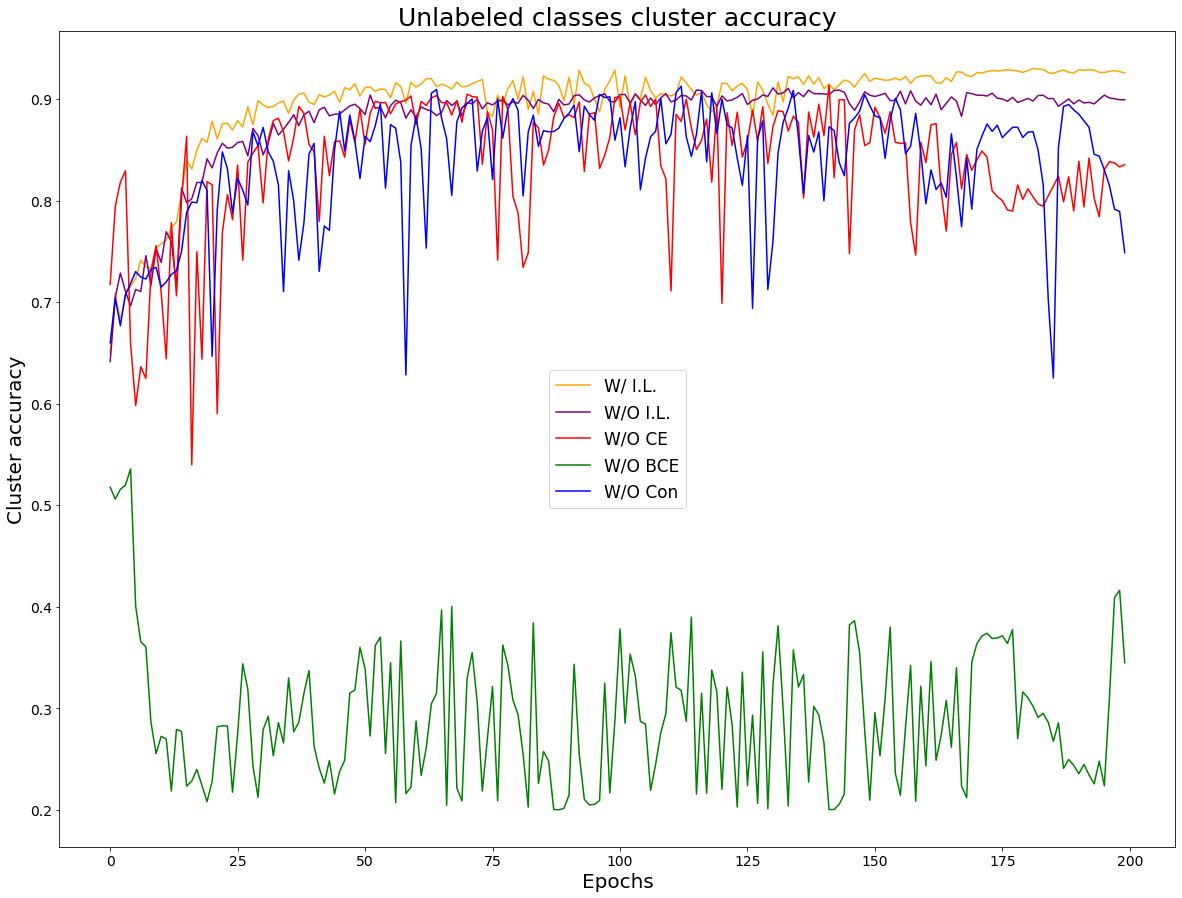

In [9]:
fig, ax= plt.subplots(figsize=(20, 15));
ax.plot(run_full.cluster_acc_Head_2.tolist(), color='orange',label="W/ I.L.") ;
ax.plot(run_NO_IL.cluster_acc_Head_2.tolist(), color='purple',label="W/O I.L.") ;
ax.plot(run_NO_CE.cluster_acc_Head_2.tolist(), color='red',label="W/O CE") ;
ax.plot(run_NO_BCE.cluster_acc_Head_2.tolist(), color='green',label="W/O BCE") ;
ax.plot(run_NO_CONS.cluster_acc_Head_2.tolist(), color='blue',label="W/O Con") ;
ax.set_xlabel('Epochs',fontsize=20);
ax.set_ylabel('Cluster accuracy',fontsize=20);
ax.set_title('Unlabeled classes cluster accuracy',fontsize=25);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', framealpha=0.8,fontsize=17)
plt.savefig('images/Novel_casses_clustey_accuracy_ts.png')
plt.show()

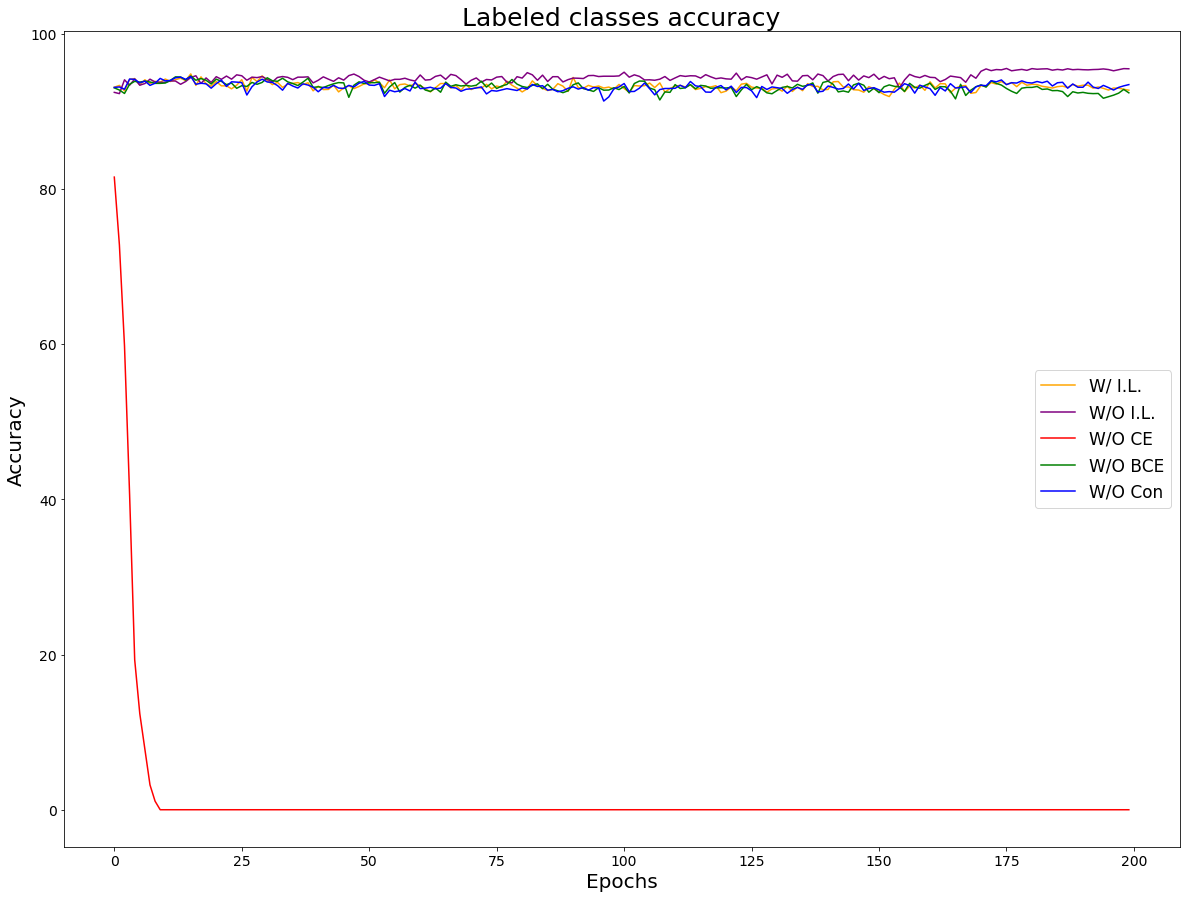

In [10]:
fig, ax= plt.subplots(figsize=(20, 15));
ax.plot(run_full.testing_acc_Head_1.tolist(), color='orange',label="W/ I.L.") ;
ax.plot(run_NO_IL.testing_acc_Head_1.tolist(), color='purple',label="W/O I.L.") ;
ax.plot(run_NO_CE.testing_acc_Head_1.tolist(), color='red',label="W/O CE") ;
ax.plot(run_NO_BCE.testing_acc_Head_1.tolist(), color='green',label="W/O BCE") ;
ax.plot(run_NO_CONS.testing_acc_Head_1.tolist(), color='blue',label="W/O Con") ;
ax.set_xlabel('Epochs',fontsize=20);
ax.set_ylabel('Accuracy',fontsize=20);
ax.set_title('Labeled classes accuracy',fontsize=25);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', framealpha=0.8,fontsize=17)
plt.savefig('images/Novel_casses_accuracy_ts.png')

plt.show()

In [11]:
# Example on how to load the models
model_dir=['./data/experiments/auto_novel/resnet_IL_cifar10_baseline.pth'
,'./data/experiments/auto_novel/resnet_IL_cifar10_ce.pth',
'./data/experiments/auto_novel/resnet_IL_cifar10_bce.pth',
'./data/experiments/auto_novel/resnet_IL_cifar10_noCONSIStency.pth',
'./data/experiments/auto_novel/resnet_cifar10_baseline_with_3_losses.pth'
]


In [12]:
def test(model, test_loader, head_flag):
    # Put the model in evaluation mode
    model.eval()
    preds = np.array([])
    targets = np.array([])
    acc_record = AverageMeter() # track the accuracy of the first head
    for batch_idx, (x, label, _) in enumerate(tqdm(test_loader)):
        x, label = x.to(device), label.to(device)

        output1, output2, _ = model(x)
        if head_flag == 'head1':
            output = output1
        else:
            output = output2
        _, pred = output.max(1)

        if head_flag == 'head1':
            acc_testing = accuracy(output, label) # calculating the accuracy
            acc_record.update(acc_testing[0].item(),x.size(0))
        else :
            acc_testing=0
        targets = np.append(targets, label.cpu().numpy())
        preds = np.append(preds, pred.cpu().numpy())
    acc, nmi, ari = cluster_acc(targets.astype(int), preds.astype(int)), nmi_score(targets, preds), ari_score(targets, preds)
    print('Test cluster acc {:.4f}, nmi {:.4f}, ari {:.4f}, test accuracy {:.4f}'.format(acc, nmi, ari,acc_record.avg))
    return acc, nmi, ari,acc_record.avg

In [13]:
Load_data= False

if not Load_data:
  df = pd.DataFrame(columns=['H1_labeled_eval_cluster_acc','H1_labeled_eval_acc','H1_unlabeled_eval_cluster_acc_test',
                             'H1_unlabeled_eval_acc_test','H1_unlabeled_eval_cluster_acc_all',
                             'H1_unlabeled_eval_acc_all','H2_labeled_eval_cluster_acc','H2_unlabeled_eval_cluster_acc_test'])
  for i in range(len(model_dir)):
    my_data = []
    model = ResNet(BasicBlock, [2, 2, 2, 2], num_labeled_classes, num_unlabeled_classes).to(device)# loading model to gpu
    if i==4:
      IL_FLAG=False
    else:
      IL_FLAG=True
    if IL_FLAG:
      model.head1 = nn.Linear(512, num_classes).to(device)
    model.load_state_dict(torch.load(model_dir[i]))
    head = 'head1'  
    cluster_accaracy,_,_,acc=test(model, labeled_eval_loader, head) # print('test on labeled classes (test split)')
    my_data.append(cluster_accaracy)
    my_data.append(acc)
    if IL_FLAG:
          cluster_accaracy,_,_,acc=test(model, unlabeled_eval_loader_test, head) #print('test on unlabeled classes (test split)')
          my_data.append(cluster_accaracy)
          my_data.append(acc)#4 take this
          cluster_accaracy,_,_,acc=test(model, all_eval_loader, head) # print('test on all classes (test split)')
          my_data.append(cluster_accaracy)# 5 take this
          my_data.append(acc)
    else: 
          my_data.append(0)
          my_data.append(0)
          my_data.append(0)
          my_data.append(0)
    head = 'head2'
    cluster_accaracy,_,_,_=test(model, unlabeled_eval_loader, head)
    my_data.append(cluster_accaracy)
    head = 'testing'
    cluster_accaracy,_,_,_=test(model, unlabeled_eval_loader_test, head)
    my_data.append(cluster_accaracy)
    df=pd.concat([df,pd.DataFrame([my_data],columns=df.columns)], ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 31.15it/s]


Test cluster acc 0.9350, nmi 0.8381, ari 0.8800, test accuracy 93.5000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.05it/s]


Test cluster acc 0.8554, nmi 0.7622, ari 0.7716, test accuracy 0.3200


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 35.67it/s]


Test cluster acc 0.8952, nmi 0.8053, ari 0.7904, test accuracy 46.9100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:05<00:00, 37.40it/s]


Test cluster acc 0.9279, nmi 0.8419, ari 0.8373, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.35it/s]


Test cluster acc 0.9196, nmi 0.8284, ari 0.8185, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 31.52it/s]


Test cluster acc 0.6318, nmi 0.5216, ari 0.4097, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 31.85it/s]


Test cluster acc 0.8556, nmi 0.7253, ari 0.6874, test accuracy 19.3600


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 34.19it/s]


Test cluster acc 0.4410, nmi 0.5376, ari 0.3367, test accuracy 9.6800


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:05<00:00, 34.57it/s]


Test cluster acc 0.8366, nmi 0.6847, ari 0.6569, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 28.31it/s]


Test cluster acc 0.8234, nmi 0.6659, ari 0.6313, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 30.56it/s]


Test cluster acc 0.9336, nmi 0.8396, ari 0.8783, test accuracy 93.3600


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.45it/s]


Test cluster acc 0.2618, nmi 0.0885, ari 0.0089, test accuracy 15.9400


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 35.39it/s]


Test cluster acc 0.5630, nmi 0.6091, ari 0.3593, test accuracy 54.6500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:05<00:00, 37.23it/s]


Test cluster acc 0.3537, nmi 0.2259, ari 0.0952, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.01it/s]


Test cluster acc 0.3496, nmi 0.2207, ari 0.0899, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.03it/s]


Test cluster acc 0.9400, nmi 0.8395, ari 0.8834, test accuracy 94.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.91it/s]


Test cluster acc 0.7040, nmi 0.5854, ari 0.5654, test accuracy 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 35.27it/s]


Test cluster acc 0.8220, nmi 0.7317, ari 0.6978, test accuracy 47.5000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:05<00:00, 36.40it/s]


Test cluster acc 0.7678, nmi 0.6209, ari 0.5957, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.03it/s]


Test cluster acc 0.7618, nmi 0.6019, ari 0.5779, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.16it/s]


Test cluster acc 0.9594, nmi 0.8729, ari 0.9021, test accuracy 95.9400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:05<00:00, 36.79it/s]


Test cluster acc 0.9060, nmi 0.7940, ari 0.7885, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.87it/s]

Test cluster acc 0.9008, nmi 0.7867, ari 0.7771, test accuracy 0.0000


In [14]:
#Load the csv above
if Load_data:
  df=pd.read_csv('evaluation_of_loses.csv')
else:
  df.to_csv('evaluation_of_loses.csv',index=False) 

height=['Baseline_IL','NO_CEL','NO_BCE','NO_CON','Baseline_NO_IL']
df['funcitons']=height
df.set_index('funcitons',inplace=True)

In [15]:
df

H1_labeled_eval_cluster_acc H1_labeled_eval_acc  \
funcitons                                                        
Baseline_IL                          0.935                93.5   
NO_CEL                              0.6318                 0.0   
NO_BCE                              0.9336               93.36   
NO_CON                                0.94                94.0   
Baseline_NO_IL                      0.9594               95.94   

               H1_unlabeled_eval_cluster_acc_test H1_unlabeled_eval_acc_test  \
funcitons                                                                      
Baseline_IL                                0.8554                       0.32   
NO_CEL                                     0.8556                      19.36   
NO_BCE                                     0.2618                      15.94   
NO_CON                                      0.704                        1.0   
Baseline_NO_IL                                  0                          0   

               H1_unlabeled_eval_cluster_acc_all H1_unlabeled_eval_acc_all  \
funcitons                                                                    
Baseline_IL                               0.8952                     46.91   
NO_CEL                                     0.441                      9.68   
NO_BCE                                     0.563                     54.65   
NO_CON                                     0.822                      47.5   
Baseline_NO_IL                                 0                         0   

               H2_labeled_eval_cluster_acc H2_unlabeled_eval_cluster_acc_test  
funcitons                                                                      
Baseline_IL                        0.92788                             0.9196  
NO_CEL                             0.83656                             0.8234  
NO_BCE                             0.35368                             0.3496  
NO_CON                             0.76776                             0.7618  
Baseline_NO_IL                       0.906                             0.9008

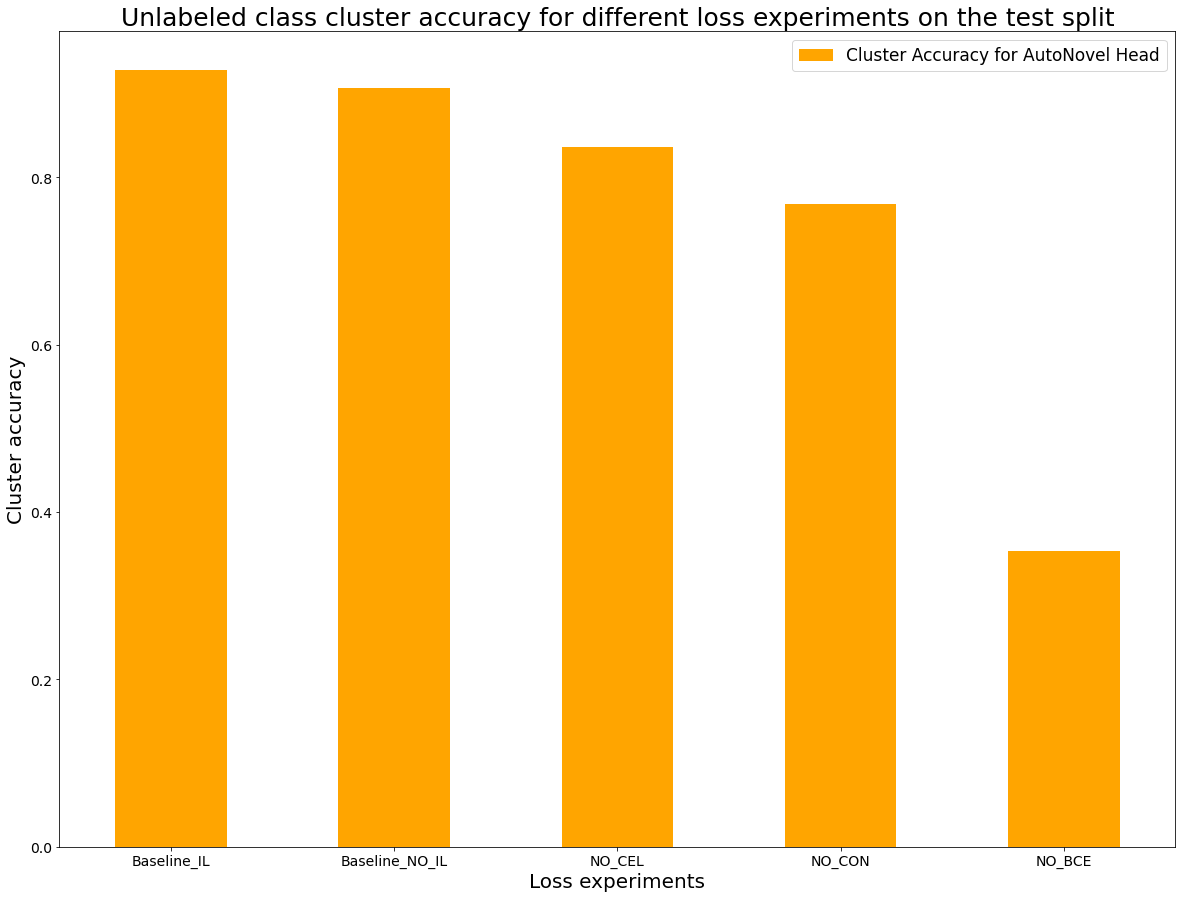

In [16]:
fig, ax= plt.subplots(figsize=(20, 15));

df['H2_labeled_eval_cluster_acc'].sort_values(ascending=False).plot(kind="bar",color='orange',label="Cluster Accuracy for AutoNovel Head") 

ax.set_xlabel('Loss experiments',fontsize=20);
ax.set_ylabel('Cluster accuracy',fontsize=20);
ax.set_title('Unlabeled class cluster accuracy for different loss experiments on the test split',fontsize=25);
plt.xticks(fontsize=14,rotation=0)
plt.yticks(fontsize=14,rotation=0)
plt.legend(loc='best', framealpha=0.8,fontsize=17)
plt.savefig('images/Novel_casses_cluster_accuracy_loss_exp_bar_train.png')
plt.show()

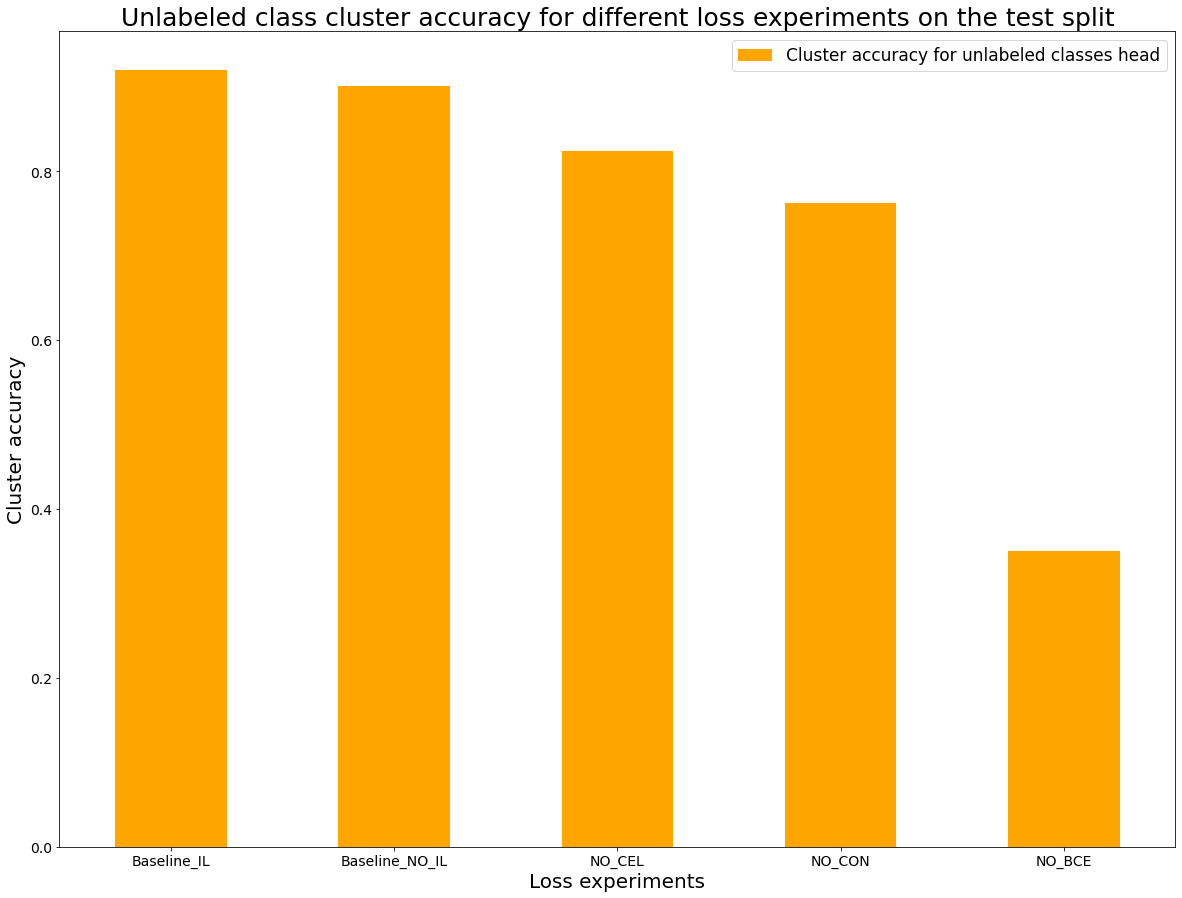

In [17]:
fig, ax= plt.subplots(figsize=(20, 15));

df['H2_unlabeled_eval_cluster_acc_test'].sort_values(ascending=False).plot(kind="bar",color='orange',label="Cluster accuracy for unlabeled classes head") 

ax.set_xlabel('Loss experiments',fontsize=20);
ax.set_ylabel('Cluster accuracy',fontsize=20);
ax.set_title('Unlabeled class cluster accuracy for different loss experiments on the test split',fontsize=25);
plt.xticks(fontsize=14,rotation=0)
plt.yticks(fontsize=14,rotation=0)
plt.legend(loc='best', framealpha=0.8,fontsize=17)
plt.savefig('images/Novel_casses_cluster_accuracy_loss_exp_bar_test.png')

plt.show()

|  Loss Exp.  | All  classes cluster accuracy (test set) | Unlabeled  classes  cluster accuracy (train set) | Unlabeled  classes cluster accuracy (test set) |
|:-----------:|:----------------------------------------:|:------------------------------------------------:|:----------------------------------------------:|
| Baseline IL |                  0.8952                  |                      0.92788                     |                     0.9196                     |
|    NO CEL   |                   0.441                  |                      0.83656                     |                     0.8234                     |
|    NO BCE   |                   0.563                  |                      0.35368                     |                     0.3496                     |
|    No CON   |                   0.822                  |                      0.76776                     |                     0.7618                     |
|    No IL    |                     -                    |                       0.906                      |                     0.9008                     |

## Topk Experiments

In [18]:
runs_loss_topk = api.runs("mhaggag96/trends_project",{"tags":"topk_experiment"})# this returned all the runs that has the tag loss experiment

In [19]:
run_names_topk=['3','100','2','1','50','20','15','10','7','5']# it returns the runs from the news to the oldest. I had weight and bias in another tab to make sure that we are folllowing this order
data_df_topk = []
for run in runs_loss_topk:
  data_df_topk.append(run.history())
test_dict = dict(zip(run_names_topk, data_df_topk)) 

In [20]:

run_names_topk=['100','2','1','50','20','15','10','7','5']# it returns the runs from the news to the oldest. I had weight and bias in another tab to make sure that we are folllowing this order
file_names=['resnet_IL_cifar10_topk_100.pth','resnet_IL_cifar10_topk_2.pth','resnet_IL_cifar10_topk_1.pth','resnet_IL_cifar10_topk_50.pth','resnet_IL_cifar10_topk_20.pth','resnet_IL_cifar10_topk_15.pth','resnet_IL_cifar10_topk_10.pth',
 'resnet_IL_cifar10_topk_7.pth','resnet_IL_cifar10_baseline.pth']

In [21]:
Load= False


In [22]:
if not Load:
  df2 = pd.DataFrame(columns=['Topk','H1_labeled_eval_cluster_acc','H1_labeled_eval_acc','H1_unlabeled_eval_cluster_acc_test','H1_unlabeled_eval_acc_test'
  ,'H1_unlabeled_eval_cluster_acc_all','H1_unlabeled_eval_acc_all','H2_labeled_eval_cluster_acc','H2_unlabeled_eval_cluster_acc_test'])
  for i in range(len(file_names)):
    my_data = []
    my_data.append(int(run_names_topk[i]))
    model = ResNet(BasicBlock, [2, 2, 2, 2], num_labeled_classes, num_unlabeled_classes).to(device)# loading model to gpu
    IL_FLAG=True
    if IL_FLAG:
      model.head1 = nn.Linear(512, num_classes).to(device)
    model.load_state_dict(torch.load('./data/experiments/auto_novel/'+file_names[i]))
    head = 'head1'  
    cluster_accaracy,_,_,acc=test(model, labeled_eval_loader, head) # print('test on labeled classes (test split)')
    my_data.append(cluster_accaracy)
    my_data.append(acc)
    if IL_FLAG:
          cluster_accaracy,_,_,acc=test(model, unlabeled_eval_loader_test, head) #print('test on unlabeled classes (test split)')
          my_data.append(cluster_accaracy)
          my_data.append(acc)
          cluster_accaracy,_,_,acc=test(model, all_eval_loader, head) # print('test on all classes (test split)')
          my_data.append(cluster_accaracy)
          my_data.append(acc)
    head = 'head2'
    cluster_accaracy,_,_,_=test(model, unlabeled_eval_loader, head)
    my_data.append(cluster_accaracy)
    head = 'testing'
    cluster_accaracy,_,_,_=test(model, unlabeled_eval_loader_test, head)
    my_data.append(cluster_accaracy)
    df2=pd.concat([df2,pd.DataFrame([my_data],columns=df2.columns)], ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.00it/s]


Test cluster acc 0.9352, nmi 0.8416, ari 0.8824, test accuracy 93.5200


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.85it/s]


Test cluster acc 0.8590, nmi 0.7640, ari 0.7733, test accuracy 0.3000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 35.58it/s]


Test cluster acc 0.8971, nmi 0.8083, ari 0.7935, test accuracy 46.9100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:05<00:00, 37.22it/s]


Test cluster acc 0.9255, nmi 0.8391, ari 0.8333, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.31it/s]


Test cluster acc 0.9216, nmi 0.8341, ari 0.8246, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.11it/s]


Test cluster acc 0.9384, nmi 0.8413, ari 0.8835, test accuracy 93.8400


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 31.84it/s]


Test cluster acc 0.8414, nmi 0.7519, ari 0.7566, test accuracy 1.9200


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 34.44it/s]


Test cluster acc 0.8899, nmi 0.8014, ari 0.7840, test accuracy 47.8800


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:05<00:00, 35.96it/s]


Test cluster acc 0.9170, nmi 0.8306, ari 0.8212, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.32it/s]


Test cluster acc 0.9110, nmi 0.8200, ari 0.8082, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.69it/s]


Test cluster acc 0.9466, nmi 0.8475, ari 0.8880, test accuracy 94.6600


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 30.77it/s]


Test cluster acc 0.6246, nmi 0.5647, ari 0.4855, test accuracy 10.3000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 34.17it/s]


Test cluster acc 0.7806, nmi 0.7268, ari 0.6556, test accuracy 52.4800


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:05<00:00, 36.66it/s]


Test cluster acc 0.7169, nmi 0.6398, ari 0.5635, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.64it/s]


Test cluster acc 0.7028, nmi 0.6206, ari 0.5437, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 31.92it/s]


Test cluster acc 0.9356, nmi 0.8375, ari 0.8803, test accuracy 93.5600


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.15it/s]


Test cluster acc 0.8576, nmi 0.7667, ari 0.7745, test accuracy 0.2800


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 34.59it/s]


Test cluster acc 0.8966, nmi 0.8080, ari 0.7926, test accuracy 46.9200


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:05<00:00, 35.38it/s]


Test cluster acc 0.9252, nmi 0.8374, ari 0.8324, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 30.29it/s]


Test cluster acc 0.9180, nmi 0.8258, ari 0.8162, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 29.37it/s]


Test cluster acc 0.9326, nmi 0.8334, ari 0.8745, test accuracy 93.2600


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 30.08it/s]


Test cluster acc 0.8532, nmi 0.7586, ari 0.7680, test accuracy 0.2800


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 35.12it/s]


Test cluster acc 0.8929, nmi 0.8024, ari 0.7859, test accuracy 46.7700


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:05<00:00, 35.18it/s]


Test cluster acc 0.9246, nmi 0.8376, ari 0.8309, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 31.41it/s]


Test cluster acc 0.9122, nmi 0.8165, ari 0.8036, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 29.28it/s]


Test cluster acc 0.9362, nmi 0.8384, ari 0.8814, test accuracy 93.6200


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 31.79it/s]


Test cluster acc 0.8552, nmi 0.7642, ari 0.7702, test accuracy 0.2400


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 34.19it/s]


Test cluster acc 0.8957, nmi 0.8079, ari 0.7921, test accuracy 46.9300


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:05<00:00, 33.59it/s]


Test cluster acc 0.9241, nmi 0.8365, ari 0.8307, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 31.53it/s]


Test cluster acc 0.9162, nmi 0.8231, ari 0.8128, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 31.91it/s]


Test cluster acc 0.9362, nmi 0.8402, ari 0.8826, test accuracy 93.6200


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 30.42it/s]


Test cluster acc 0.8542, nmi 0.7615, ari 0.7696, test accuracy 0.3200


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 34.29it/s]


Test cluster acc 0.8952, nmi 0.8061, ari 0.7909, test accuracy 46.9700


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:05<00:00, 36.43it/s]


Test cluster acc 0.9247, nmi 0.8392, ari 0.8320, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 31.99it/s]


Test cluster acc 0.9186, nmi 0.8311, ari 0.8180, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.83it/s]


Test cluster acc 0.9372, nmi 0.8406, ari 0.8826, test accuracy 93.7200


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 31.94it/s]


Test cluster acc 0.8528, nmi 0.7636, ari 0.7669, test accuracy 0.2800


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 34.54it/s]


Test cluster acc 0.8950, nmi 0.8083, ari 0.7913, test accuracy 47.0000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:05<00:00, 35.68it/s]


Test cluster acc 0.9231, nmi 0.8417, ari 0.8313, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.89it/s]


Test cluster acc 0.9192, nmi 0.8365, ari 0.8225, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.19it/s]


Test cluster acc 0.9350, nmi 0.8381, ari 0.8800, test accuracy 93.5000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.66it/s]


Test cluster acc 0.8554, nmi 0.7622, ari 0.7716, test accuracy 0.3200


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 35.05it/s]


Test cluster acc 0.8952, nmi 0.8053, ari 0.7904, test accuracy 46.9100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:05<00:00, 36.46it/s]


Test cluster acc 0.9279, nmi 0.8419, ari 0.8373, test accuracy 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.43it/s]

Test cluster acc 0.9196, nmi 0.8284, ari 0.8185, test accuracy 0.0000


In [23]:
df2.sort_values(by=['Topk'],inplace=True)

In [24]:
#Load the csv above
if Load:
  df2=pd.read_csv('evaluation_of_topk.csv')
else:
  df2.to_csv('evaluation_of_topk.csv',index=False) 

In [25]:
df2

Topk H1_labeled_eval_cluster_acc H1_labeled_eval_acc  \
2    1                      0.9466               94.66   
1    2                      0.9384               93.84   
8    5                       0.935                93.5   
7    7                      0.9372               93.72   
6   10                      0.9362               93.62   
5   15                      0.9362               93.62   
4   20                      0.9326               93.26   
3   50                      0.9356               93.56   
0  100                      0.9352               93.52   

  H1_unlabeled_eval_cluster_acc_test H1_unlabeled_eval_acc_test  \
2                             0.6246                       10.3   
1                             0.8414                       1.92   
8                             0.8554                       0.32   
7                             0.8528                       0.28   
6                             0.8542                       0.32   
5                             0.8552                       0.24   
4                             0.8532                       0.28   
3                             0.8576                       0.28   
0                              0.859                        0.3   

  H1_unlabeled_eval_cluster_acc_all H1_unlabeled_eval_acc_all  \
2                            0.7806                     52.48   
1                            0.8899                     47.88   
8                            0.8952                     46.91   
7                             0.895                      47.0   
6                            0.8952                     46.97   
5                            0.8957                     46.93   
4                            0.8929                     46.77   
3                            0.8966                     46.92   
0                            0.8971                     46.91   

  H2_labeled_eval_cluster_acc H2_unlabeled_eval_cluster_acc_test  
2                     0.71692                             0.7028  
1                     0.91696                              0.911  
8                     0.92788                             0.9196  
7                     0.92312                             0.9192  
6                     0.92472                             0.9186  
5                     0.92412                             0.9162  
4                      0.9246                             0.9122  
3                      0.9252                              0.918  
0                     0.92548                             0.9216

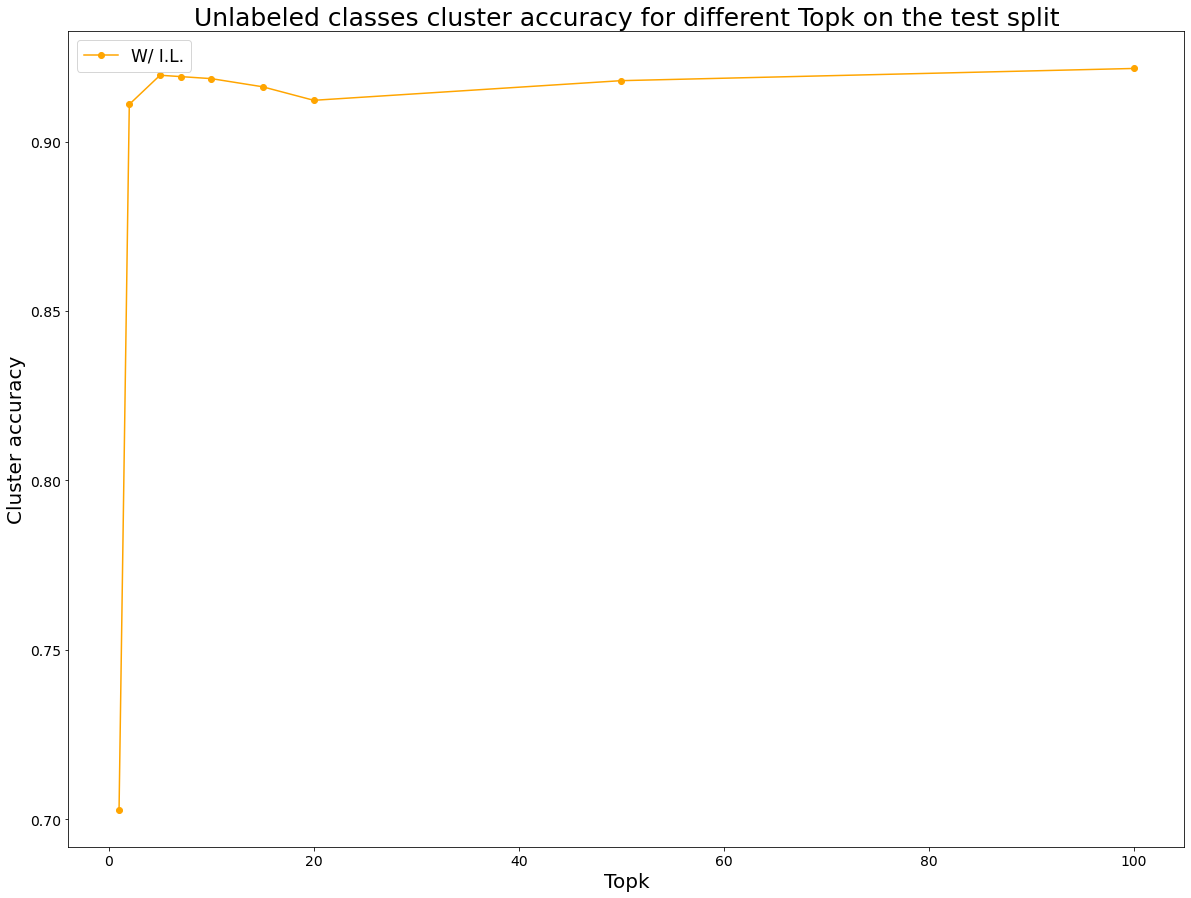

In [26]:
fig, ax= plt.subplots(figsize=(20, 15));
ax.plot(df2['Topk'].tolist(),df2['H2_unlabeled_eval_cluster_acc_test'].tolist(),'-o', color='orange',label="W/ I.L.") 

ax.set_xlabel('Topk',fontsize=20);
ax.set_ylabel('Cluster accuracy',fontsize=20);
ax.set_title('Unlabeled classes cluster accuracy for different Topk on the test split',fontsize=25);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', framealpha=0.8,fontsize=17)
plt.savefig('images/Novel_casses_cluster_accuracy_top_k_exp.png')
plt.show()

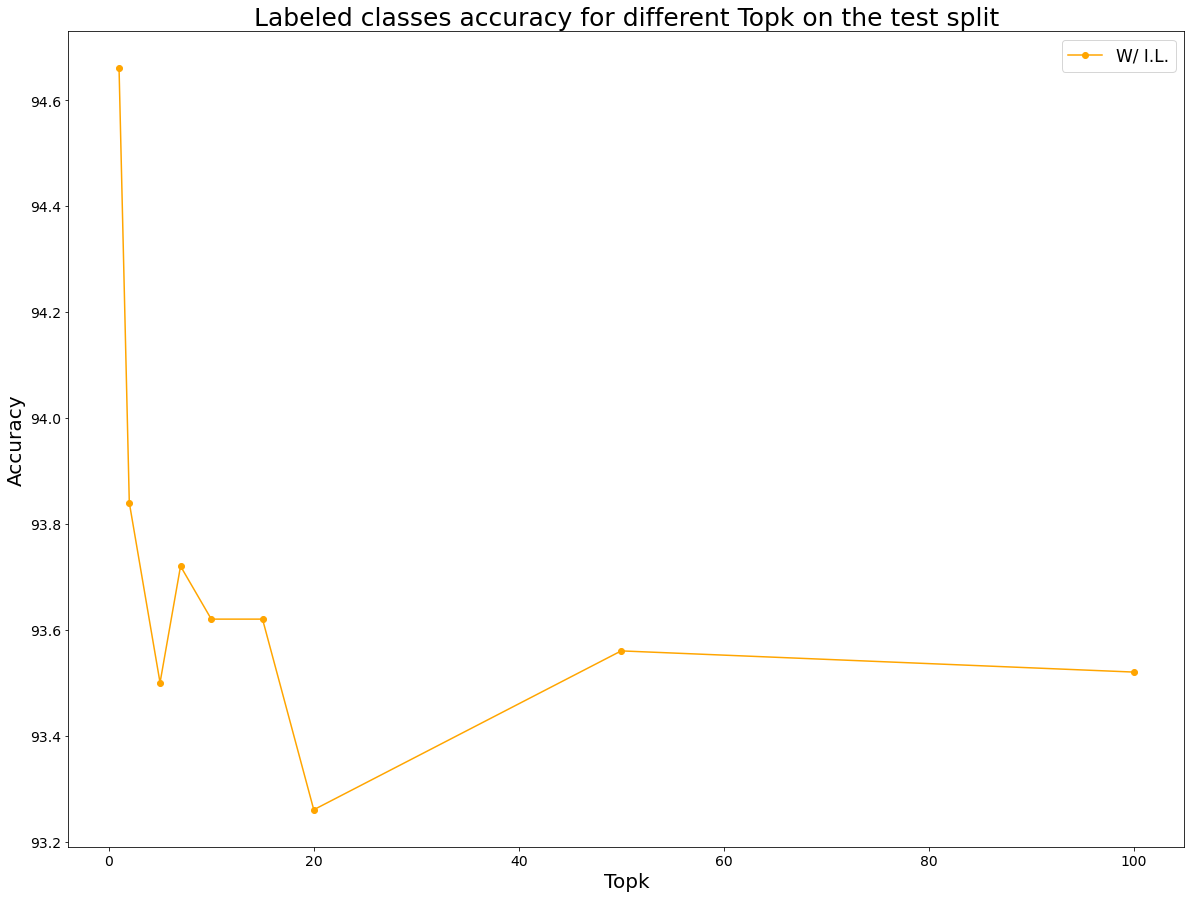

In [27]:
fig, ax= plt.subplots(figsize=(20, 15));
# ax.plot(df2['Topk'].tolist(),df2['H1_labeled_eval_cluster_acc'].tolist(),'-o', color='orange',label="W/ I.L.") 
ax.plot(df2['Topk'].tolist(),df2['H1_labeled_eval_acc'].tolist(),'-o', color='orange',label="W/ I.L.") 


ax.set_xlabel('Topk',fontsize=20);
ax.set_ylabel('Accuracy',fontsize=20);
ax.set_title('Labeled classes accuracy for different Topk on the test split',fontsize=25);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', framealpha=0.8,fontsize=17)
plt.savefig('images/Labeled_classes_accuracy_top_k_exp.png')
plt.show()

| Topk | All  classes cluster accuracy (test set) | Unlabeled  classes  cluster accuracy (train set) | Unlabeled  classes cluster accuracy (test set) |
|:----:|:----------------------------------------:|:------------------------------------------------:|:----------------------------------------------:|
|   1  |                  0.7806                  |                      0.71692                     |                     0.7028                     |
|   2  |                  0.8899                  |                      0.91696                     |                      0.911                     |
|   5  |                  0.8952                  |                      0.92788                     |                     0.9196                     |
|   7  |                  0.8950                  |                      0.92312                     |                     0.9192                     |
|  10  |                  0.8952                  |                      0.92472                     |                     0.9186                     |
|  15  |                  0.8957                  |                      0.92412                     |                     0.9162                     |
|  20  |                  0.8929                  |                      0.9246                      |                     0.9122                     |
|  50  |                  0.8966                  |                      0.9252                      |                      0.918                     |
|  100 |                  0.8971                  |                      0.92548                     |                     0.9216                     |

## Remmove SSL

In [28]:
run_supervised_NOSSL = api.run("mhaggag96/trends_project/3004g3l7").history()
run_supervised = api.run("mhaggag96/trends_project/1ozov6s6").history()
run_autonovel_NOSSL = api.run("mhaggag96/trends_project/19kfhlcc").history()
run_autonovel = api.run("mhaggag96/trends_project/3s9gdgx5").history()

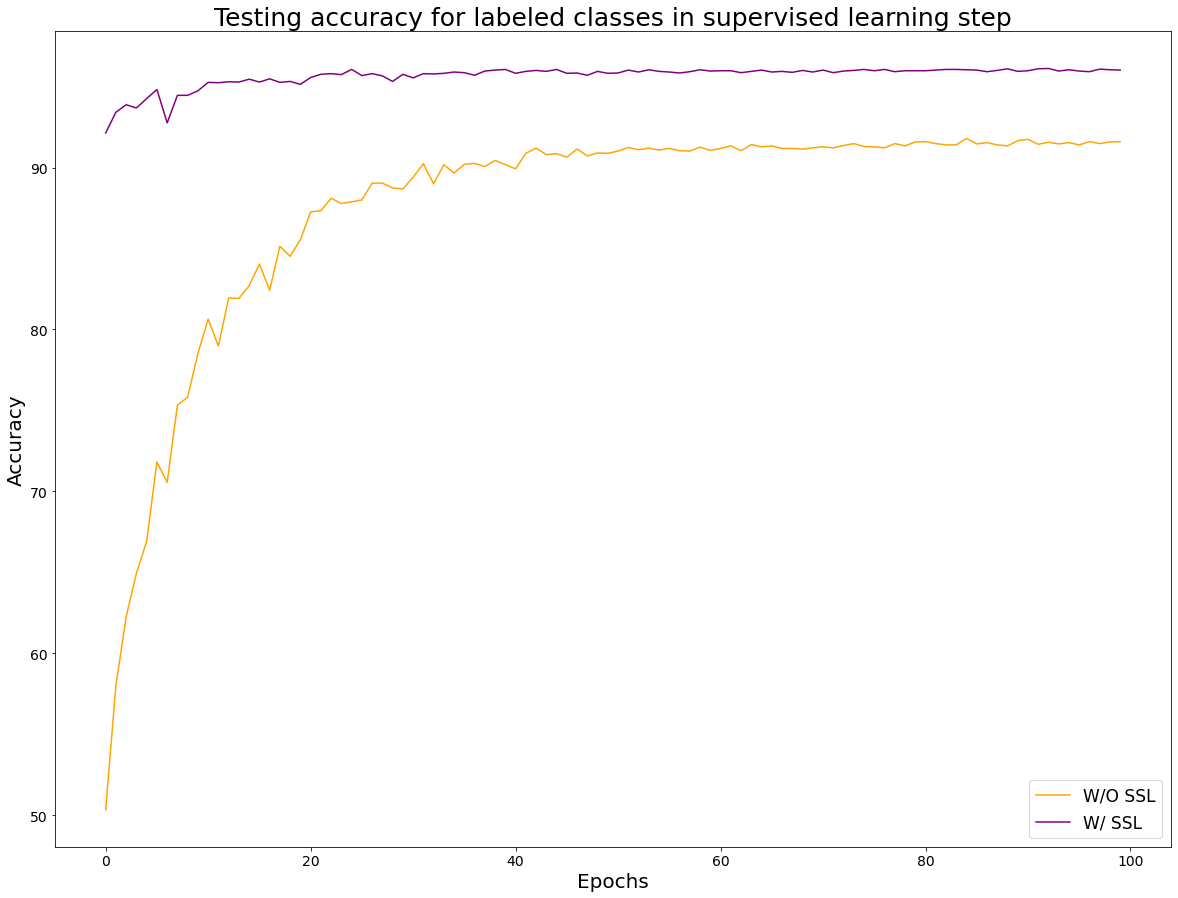

In [29]:
fig, ax= plt.subplots(figsize=(20, 15));
ax.plot(run_supervised_NOSSL.testing_acc_Head_1.tolist(), color='orange',label="W/O SSL") ;
ax.plot(run_supervised.testing_acc_Head_1.tolist(), color='purple',label="W/ SSL ") ;
ax.set_xlabel('Epochs',fontsize=20);
ax.set_ylabel('Accuracy',fontsize=20);
ax.set_title('Testing accuracy for labeled classes in supervised learning step',fontsize=25);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', framealpha=0.8,fontsize=17)
plt.savefig('images/Generating_graphs_for_testing_accuracy_in_Super_STEP_noemi_exp.png')
plt.show()

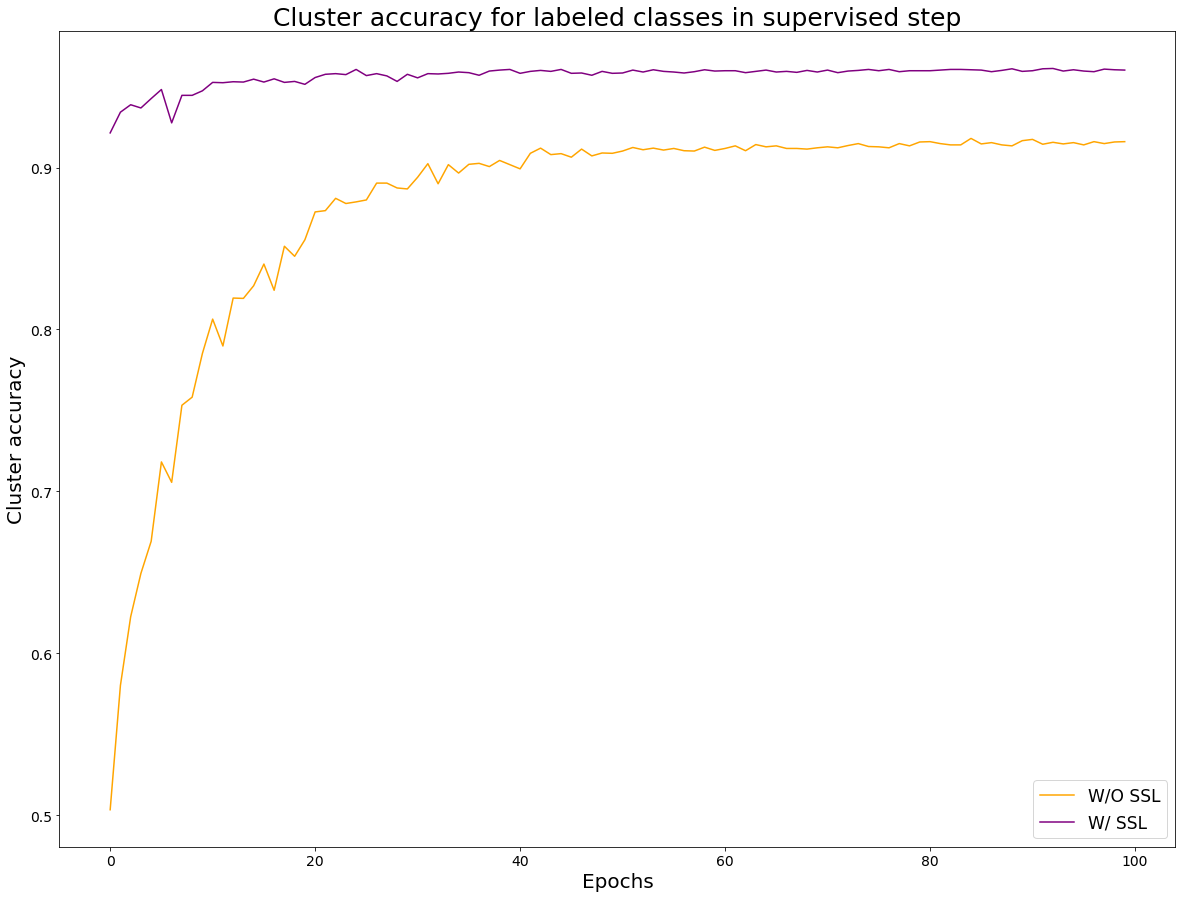

In [30]:
fig, ax= plt.subplots(figsize=(20, 15));
ax.plot(run_supervised_NOSSL.cluster_acc_Head_1.tolist(), color='orange',label="W/O SSL") ;
ax.plot(run_supervised.cluster_acc_Head_1.tolist(), color='purple',label="W/ SSL ") ;
ax.set_xlabel('Epochs',fontsize=20);
ax.set_ylabel('Cluster accuracy',fontsize=20);
ax.set_title('Cluster accuracy for labeled classes in supervised step',fontsize=25);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', framealpha=0.8,fontsize=17)
# plt.grid()
plt.savefig('images/Generating_graphs_for_cluster_accuracy_in_Super_STEP_noemi_exp.png')
plt.show()


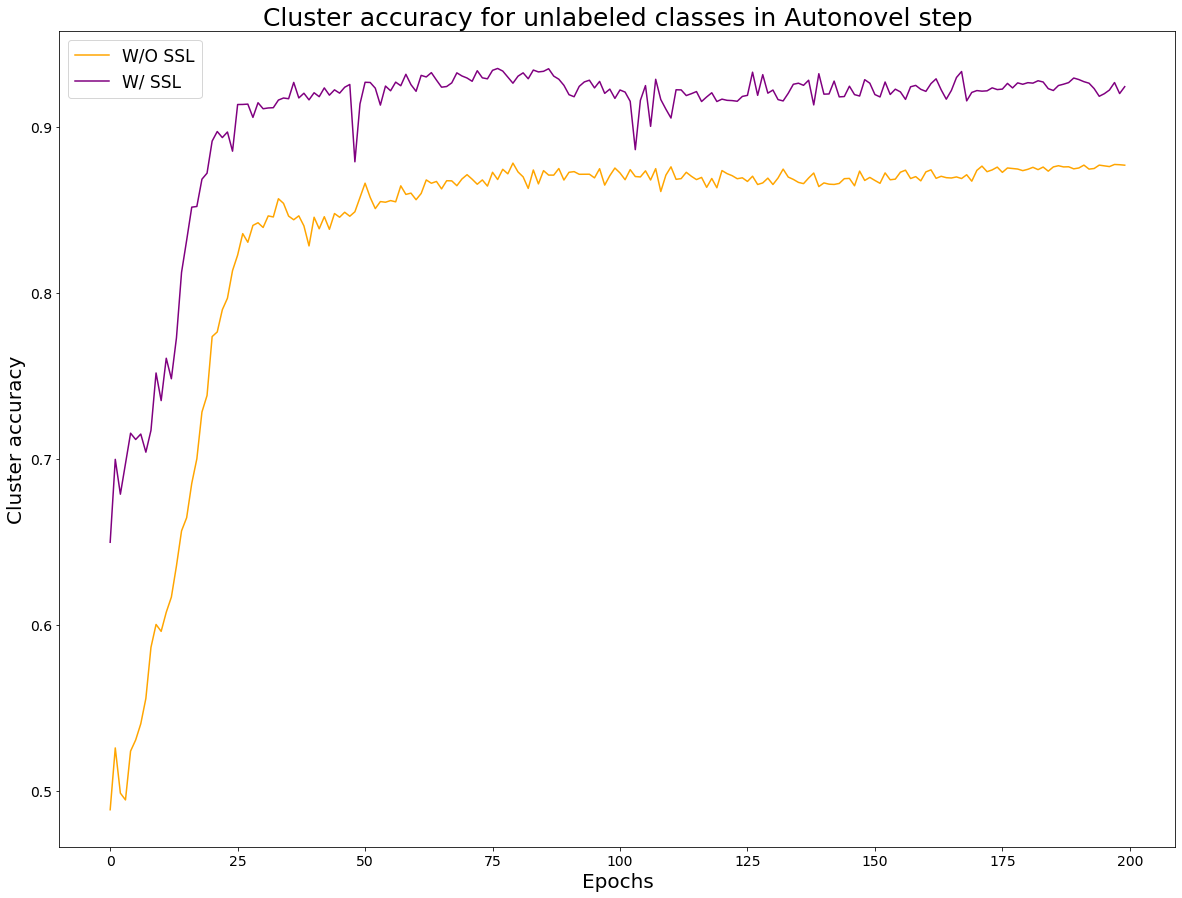

In [31]:
fig, ax= plt.subplots(figsize=(20, 15));
ax.plot(run_autonovel_NOSSL.cluster_acc_Head_2.tolist(), color='orange',label="W/O SSL") ;
ax.plot(run_autonovel.cluster_acc_Head_2.tolist(), color='purple',label="W/ SSL ") ;
ax.set_xlabel('Epochs',fontsize=20);
ax.set_ylabel('Cluster accuracy',fontsize=20);
ax.set_title('Cluster accuracy for unlabeled classes in Autonovel step',fontsize=25);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', framealpha=0.8,fontsize=17)
plt.savefig('images/Generating_graphs_for_cluster_accuracy_in_AUTONOVEL_STEP_noemi_exp.png')
plt.show()

## Change of architecutre

In [32]:
## STEP 1
run_old_SSL = api.run("mhaggag96/trends_project/1ni39qdj").history()
run_new_SSL = api.run("mhaggag96/trends_project/1o6drm9k").history()
run_old_SSL_model = 'data/experiments/selfsupervised_learning/rotnet_cifar10_basicconfig.pth'
run_new_SSL_model = 'data/experiments/selfsupervised_learning/rotnet_cifar10_new_config.pth'



### analysis on SSL step 

In [33]:
from selfsupervised_learning import resnet_sim
from models.resnet import BasicBlock
from selfsupervised_learning import test


In [34]:
global is_adapters  # TODO: Does anyone know what is the use of this??? what happens if I change its value ????
is_adapters = 0
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        # Initial Convolution + BatchNormalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # Append ResNet18 layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # Implement a final linear layer to classify between the given classes. This head will be used only to perform
        # this unsupervised classification task (RotNet), and will be removed in the next task (Supervised training)
        self.linear = nn.Linear(512 * block.expansion, num_classes)
        # If is_adapters is true then add a parallel_convolution layer
        if is_adapters:  # Not used since adapters is set to 0
            self.parallel_conv1 = nn.Conv2d(3, 64, kernel_size=1, stride=1, bias=False)

    def _make_layer(self, block, planes, num_blocks, stride):
        # Compute a strides list for the different blocks. Use the input argument stride for the first block
        # (this allows to reduce the dimension if it is >1), then use stride=1 for all the other layers in the block
        strides = [stride] + [1] * (num_blocks - 1)
        # Define an empty list of layers
        layers = []
        # Each layer is composed of a set of blocks with the previously defined strides
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion  # Block expansion is set to 1 in the BasicBlock class
        return nn.Sequential(*layers)

    def forward(self, x):
        # Compute the output of the NN
        # If is adapters is true consider also the parallel convolution in the computation of the output
        if is_adapters:  # TODO:How is is_adapters used and defined??
            out = F.relu(self.bn1(self.conv1(x) + self.parallel_conv1(x)))
        # Otherwise consider just the previous layers
        else:
            out = F.relu(self.bn1(self.conv1(x)))
        # Compute the output through all the ResNet layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [35]:
from data.rotationloader import DataLoader, GenericDataset
dataset_test = GenericDataset(
            dataset_name='cifar10',
            split='test',
            dataset_root='./data/datasets/CIFAR/'
        )
dloader_test = DataLoader(
            dataset=dataset_test,
            batch_size=64,
            num_workers=4,
            shuffle=False)

Files already downloaded and verified


In [36]:
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=4)
model.load_state_dict(torch.load(run_old_SSL_model))
model_2 = resnet_sim(num_labeled_classes=4)
model_2.load_state_dict(torch.load(run_new_SSL_model))

<All keys matched successfully>

In [37]:
def test(model, device, dataloader, epoch):
    # Define an instance of AverageMeter to compute and store the average and current values of the accuracy
    acc_record = AverageMeter()
    # Put the model in evaluation mode
    model.eval()
    # Iterate through the dataloader using tqdm to print a graphic progress bar
    for batch_idx, (data, label) in enumerate(tqdm(dataloader())):
        # Move both data and label to gpu, the data has input (256,3,32,32)
        data, label = data.to(device), label.to(device)
        # Compute the output of the model for the input data. Output dimension (256,4)
        output = model(data)

        # Compute the accuracy using the accuracy() function from the file utils.py
        # Also in this call the argument 'topk' is not passed, so it is set to default value of (1,)
        acc = accuracy(output, label)
        # Update the accuracy AverageMeter object with the values just computed
        acc_record.update(acc[0].item(), data.size(0))

    # Print the result of the testing procedure
    print('Test Acc: {:.4f}'.format(acc_record.avg))
    return acc_record

In [38]:
model.to(device)
acc_record = test(model, device, dloader_test, 0)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 19.86it/s]

Test Acc: 96.0850


In [39]:
model_2.to(device)
acc_record = test(model_2, device, dloader_test, 0)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 20.77it/s]

Test Acc: 95.5500


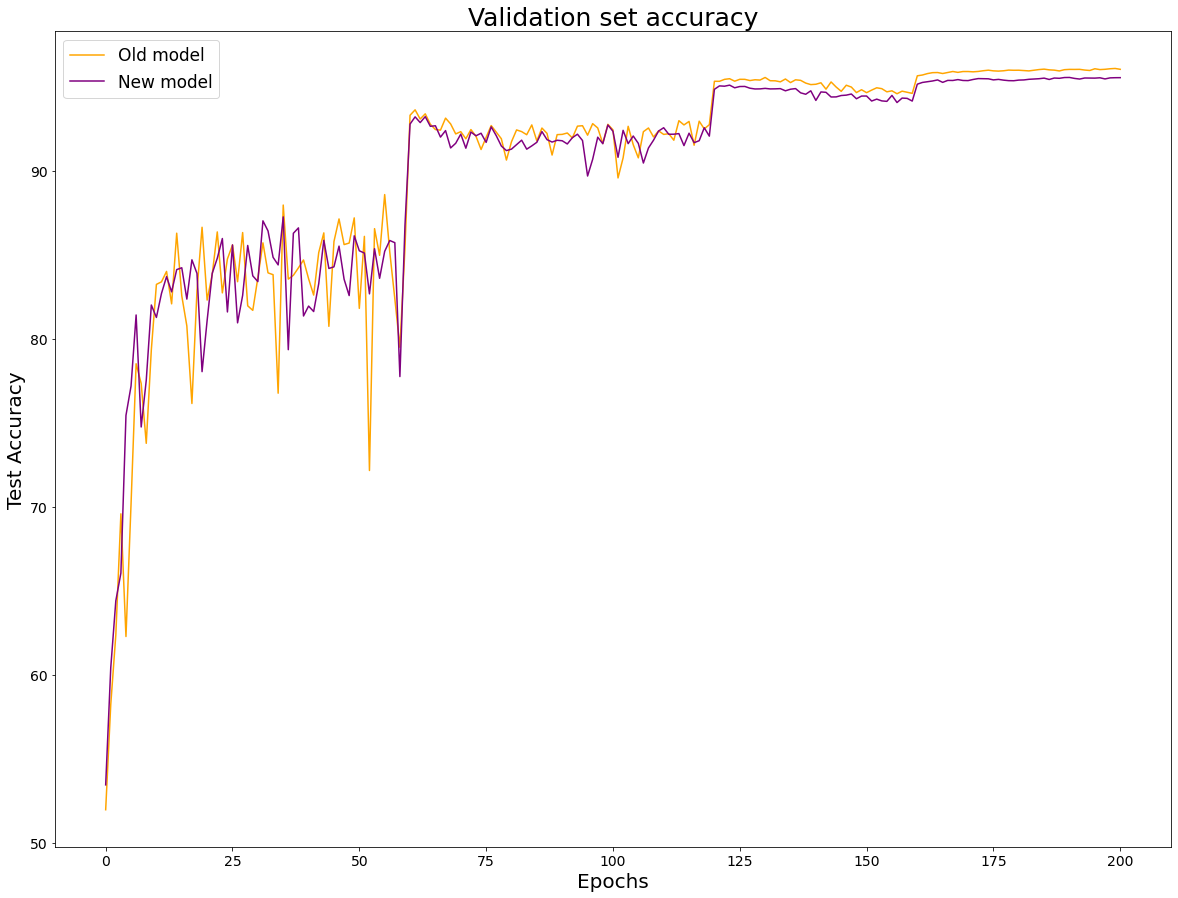

In [40]:
fig, ax= plt.subplots(figsize=(20, 15));
ax.plot(run_old_SSL.Head_1_val_accuracy.tolist(), color='orange',label="Old model") ;
ax.plot(run_new_SSL.Head_1_val_accuracy.tolist(), color='purple',label="New model") ;

ax.set_xlabel('Epochs',fontsize=20);
ax.set_ylabel('Test Accuracy',fontsize=20);
ax.set_title('Validation set accuracy',fontsize=25);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', framealpha=0.8,fontsize=17)

plt.show()

### anaylsis of SL

In [41]:
from models.resnet import BasicBlock,resnet_sim,ResNet
from utils.util import cluster_acc, Identity, AverageMeter, accuracy
from data.cifarloader import CIFAR10Loader, CIFAR10LoaderMix

In [42]:
## STEP 2
run_old_SL = api.run("mhaggag96/trends_project/vp78kjp8").history()
run_new_SL = api.run("mhaggag96/trends_project/2sderoky").history()
run_old_SL_model = 'data/experiments/supervised_learning/resnet_rotnet_cifar10_basicconfig.pth'
run_new_SL_model = 'data/experiments/supervised_learning/resnet_rotnet_cifar10_new_config.pth'

In [43]:
model=ResNet(BasicBlock, [2, 2, 2, 2], 5, 5).to(device)
model.load_state_dict(torch.load(run_old_SL_model))
model_2 = resnet_sim(5, 5).to(device)
model_2.load_state_dict(torch.load(run_new_SL_model))

<All keys matched successfully>

In [44]:
def test(model, test_loader):
    model.eval()
    preds = np.array([])
    targets = np.array([])
    acc_record = AverageMeter()  # track the accuracy of the first head

    for batch_idx, (x, label, _) in enumerate(tqdm(test_loader)):
        x, label = x.to(device), label.to(device)
        output1, output2, _ = model(x)
        output = output1
        _, pred = output.max(1)
        acc_testing = accuracy(output, label)  # calculating the accuracy
        acc_record.update(acc_testing[0].item(), x.size(0))
        targets = np.append(targets, label.cpu().numpy())
        preds = np.append(preds, pred.cpu().numpy())
    acc, nmi, ari = cluster_acc(targets.astype(int), preds.astype(int)), nmi_score(targets, preds), ari_score(targets,
                                                                                                              preds)
    print('Test cluster acc {:.4f}, nmi {:.4f}, ari {:.4f}, test accuracy {:.4f}'.format(acc, nmi, ari, acc_record.avg))
    return acc, nmi, ari, acc_record.avg

In [45]:
labeled_eval_loader = CIFAR10Loader(root='./data/datasets/CIFAR/', batch_size=128, split='test',
                                            aug=None, shuffle=False, target_list=range(5))

In [46]:
acc_H1, nmi_H1, ari_H1, acc_testing_H1 =test(model, labeled_eval_loader)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.10it/s]

Test cluster acc 0.9584, nmi 0.8694, ari 0.8994, test accuracy 95.8400


In [47]:
acc_H1, nmi_H1, ari_H1, acc_testing_H1 =test(model_2, labeled_eval_loader)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.16it/s]

Test cluster acc 0.9476, nmi 0.8421, ari 0.8744, test accuracy 94.7600


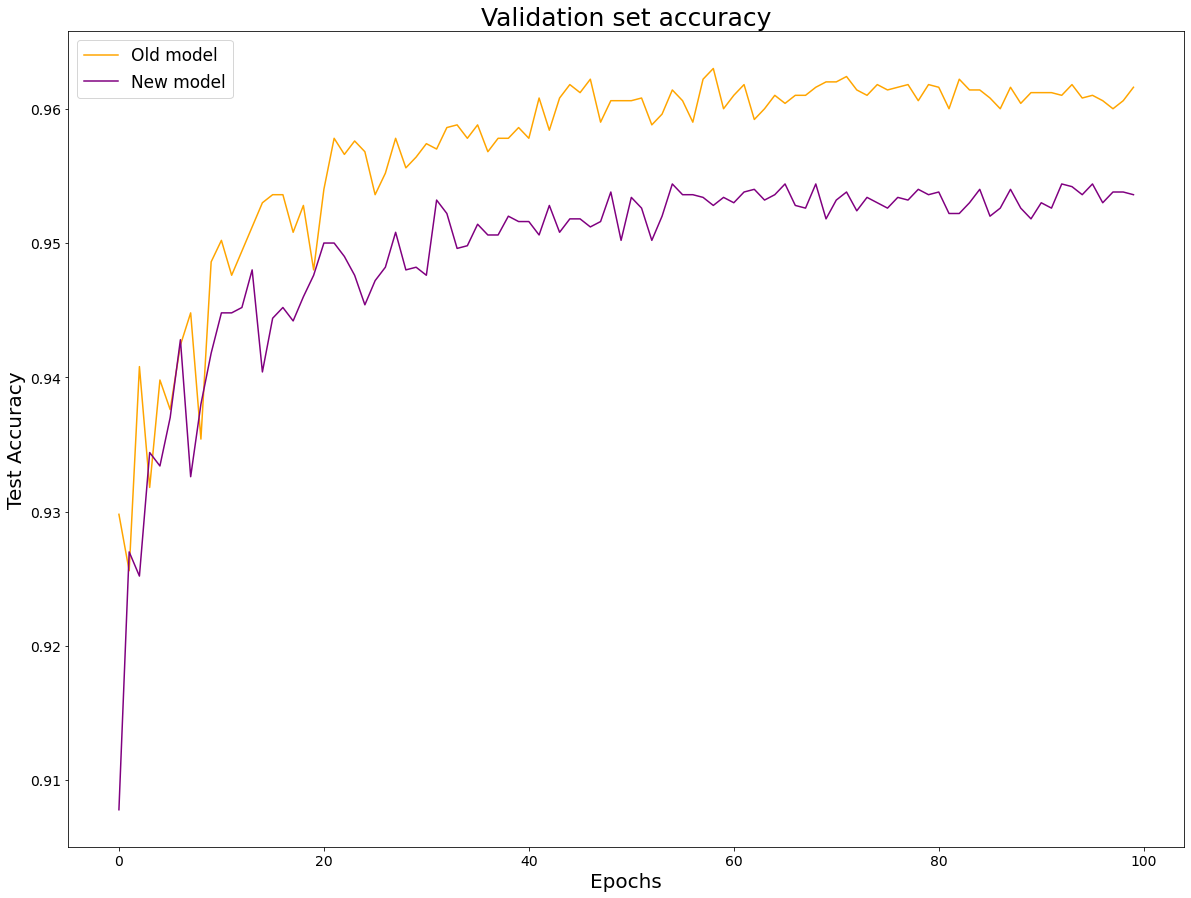

In [48]:
fig, ax= plt.subplots(figsize=(20, 15));
ax.plot(run_old_SL.cluster_acc_Head_1.tolist(), color='orange',label="Old model") ;
ax.plot(run_new_SL.cluster_acc_Head_1.tolist(), color='purple',label="New model") ;

ax.set_xlabel('Epochs',fontsize=20);
ax.set_ylabel('Test Accuracy',fontsize=20);
ax.set_title('Validation set accuracy',fontsize=25);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', framealpha=0.8,fontsize=17)

plt.show()

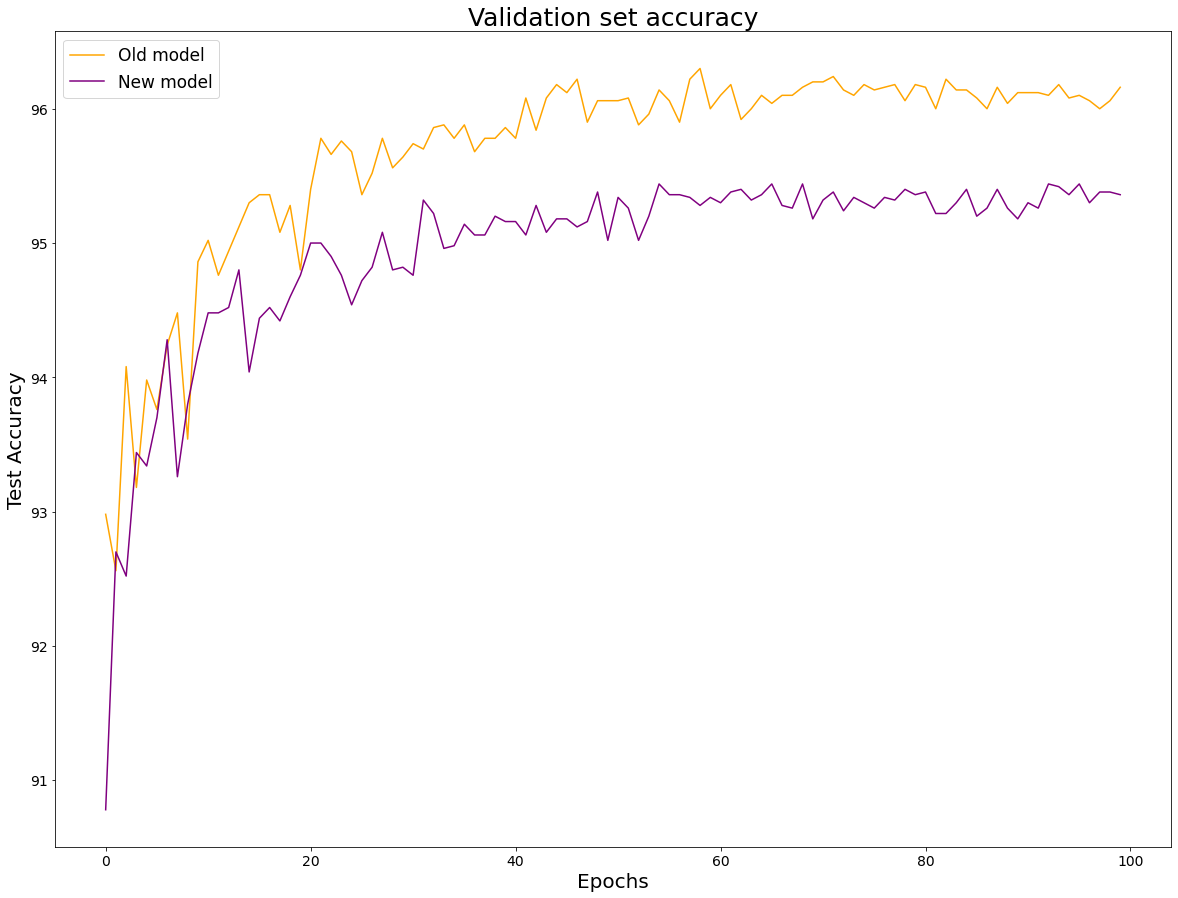

In [49]:
fig, ax= plt.subplots(figsize=(20, 15));
ax.plot(run_old_SL.testing_acc_Head_1.tolist(), color='orange',label="Old model") ;
ax.plot(run_new_SL.testing_acc_Head_1.tolist(), color='purple',label="New model") ;

ax.set_xlabel('Epochs',fontsize=20);
ax.set_ylabel('Test Accuracy',fontsize=20);
ax.set_title('Validation set accuracy',fontsize=25);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', framealpha=0.8,fontsize=17)

plt.show()

### analysis of NCD

In [50]:
## STEP 3
run_old_NCL = api.run("mhaggag96/trends_project/1ggpmba1").history()
run_new_NCL = api.run("mhaggag96/trends_project/2wov4ow5").history()
run_old_NCL_model = 'data/experiments/auto_novel/resnet_IL_cifar10_basic_config.pth'
run_new_NCL_model = 'data/experiments/auto_novel/resnet_IL_cifar10_new_config.pth'

In [51]:


def test(model, test_loader,args):
    # Put the model in evaluation mode
    model.eval()
    # Instantiate two numpy arrays, one for predictions and oen for targets
    preds = np.array([])
    targets = np.array([])
    acc_record = AverageMeter()  # track the accuracy of the first head
    # loss_record = AverageMeter()

    # Iterate for each batch in the dataloader
    for batch_idx, (x, label, _) in enumerate(tqdm(test_loader)):
        # Dataloader contain: X(input sample), label(sample label), index(index of sample in the original dataset)
        # We are interested in using just the sample x and its label to perform supervised learning
        x, label = x.to(device), label.to(device)

        # Output 1, Output2 and Output3 are the results of Head1, Head2, and features-layer4 respectively, we take the
        # outputs of the two heads since we are interested in testing the accuracy of one of the two
        output1, output2, _ = model(x)

        # If the argument head is 'head1' then we take as final output the result of the supervised head
        if args['head'] == 'head1':
            # output1 has size of (128,5), since the batch_size is 128 and the possible classes are 5
            output = output1
        # Otherwise, we take as final output the result of the unsupervised head
        else:
            output = output2
            # label-=args.num_labeled_classes

        # Returns the maximum value for each element in the input tensor, therefore we move from size (128,5) to (128)
        # Here we are not interested in the value, so we put '_' for the first term. We are interested in the second
        # term, which is the index of that value, since the index is equal to the predicted class for that input sample.
        _, pred = output.max(1)

        # Convert tensor to numpy using 'X.cpu.numpy', then append the value in the respective numpy array
        if args['head'] == 'head1':
            acc_testing = accuracy(output, label)  # calculating the accuracy
            acc_record.update(acc_testing[0].item(), x.size(0))
        else:
            acc_testing = 0
        targets = np.append(targets, label.cpu().numpy())
        preds = np.append(preds, pred.cpu().numpy())

    # Compute the accuracy metrics for the current test step, see supervised_learning.py for full explanation
    acc, nmi, ari = cluster_acc(targets.astype(int), preds.astype(int)), nmi_score(targets, preds), ari_score(targets,
                                                                                                              preds)

    print('Test cluster acc {:.4f}, nmi {:.4f}, ari {:.4f}, test accuracy {:.4f}'.format(acc, nmi, ari, acc_record.avg))
    return acc, nmi, ari, acc_record.avg

In [52]:
model=ResNet(BasicBlock, [2, 2, 2, 2], 5, 5).to(device)
model.head1 = nn.Linear(512, 10).to(device)
model.load_state_dict(torch.load(run_old_NCL_model))
model_2 = resnet_sim(5, 5).to(device)
model_2.head1 = nn.Linear(512, 10).to(device)
model_2.load_state_dict(torch.load(run_new_NCL_model))

<All keys matched successfully>

In [53]:
unlabeled_eval_loader = CIFAR10Loader(root='./data/datasets/CIFAR/', batch_size=128, split='train',
                                              aug=None, shuffle=False,
                                              target_list=range(5, 10))
unlabeled_eval_loader_test = CIFAR10Loader(root='./data/datasets/CIFAR/', batch_size=128, split='test',
                                                   aug=None, shuffle=False,
                                                   target_list=range(5, 10))
labeled_eval_loader = CIFAR10Loader(root='./data/datasets/CIFAR/', batch_size=128, split='test',
                                            aug=None, shuffle=False, target_list=range(5))

In [54]:
args={"head":"head2"}

In [55]:
args['head']

'head2'

In [56]:
test(model, unlabeled_eval_loader,  args)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:05<00:00, 37.76it/s]


Test cluster acc 0.9202, nmi 0.8320, ari 0.8201, test accuracy 0.0000


(0.9202, 0.8320104161918431, 0.8201387124443089, 0)

In [57]:
test(model, unlabeled_eval_loader_test,  args)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.18it/s]


Test cluster acc 0.9146, nmi 0.8220, ari 0.8069, test accuracy 0.0000


(0.9146, 0.8219752618659001, 0.8068902802256295, 0)

In [58]:
test(model_2, unlabeled_eval_loader,  args)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:05<00:00, 38.66it/s]

Test cluster acc 0.9030, nmi 0.7918, ari 0.7812, test accuracy 0.0000


(0.90296, 0.7918218103415373, 0.7812178564442299, 0)

In [59]:
test(model_2, unlabeled_eval_loader_test,  args)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.23it/s]

Test cluster acc 0.8970, nmi 0.7822, ari 0.7681, test accuracy 0.0000


(0.897, 0.7821943685816475, 0.7680634247203061, 0)

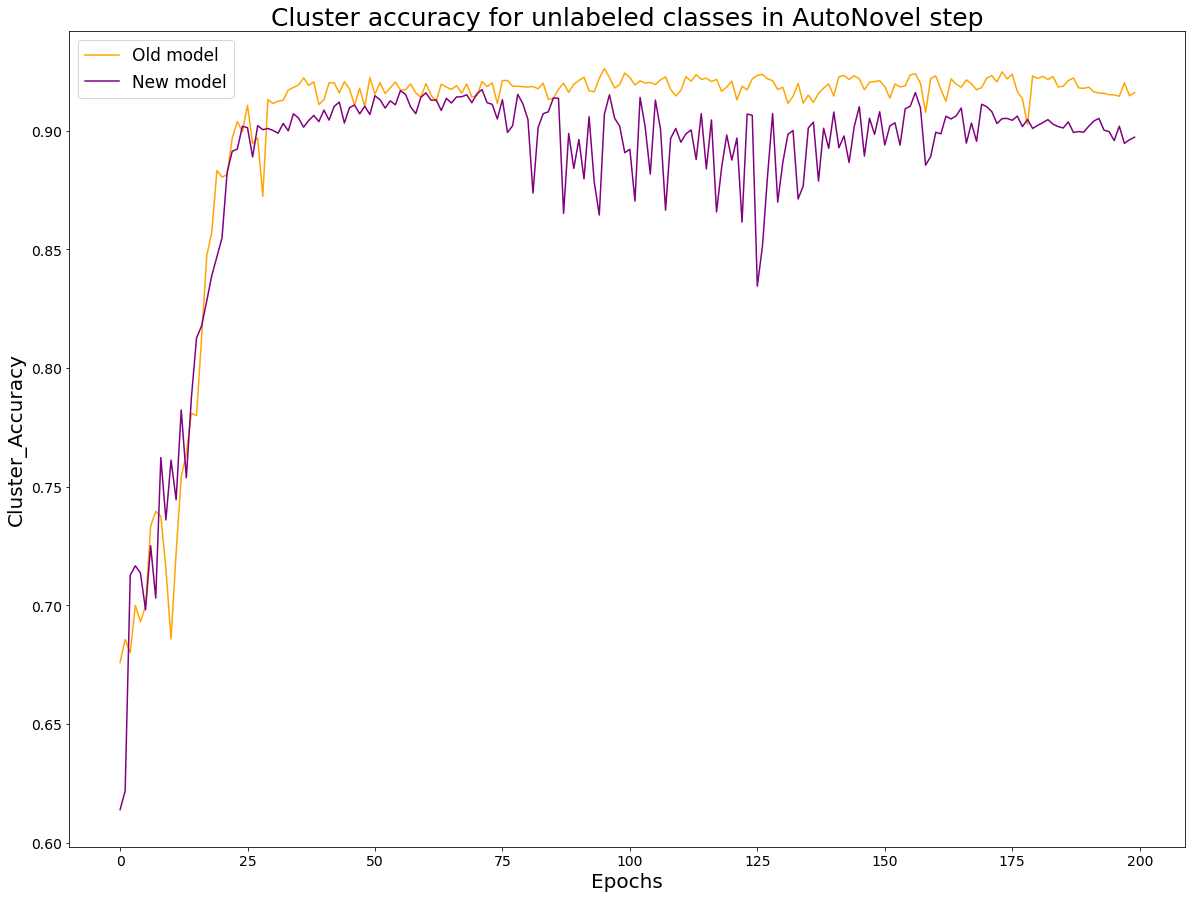

In [60]:
fig, ax= plt.subplots(figsize=(20, 15));
ax.plot(run_old_NCL.cluster_acc_Head_2.tolist(), color='orange',label="Old model") ;
ax.plot(run_new_NCL.cluster_acc_Head_2.tolist(), color='purple',label="New model") ;

ax.set_xlabel('Epochs',fontsize=20);
ax.set_ylabel('Cluster_Accuracy',fontsize=20);
ax.set_title('Cluster accuracy for unlabeled classes in AutoNovel step',fontsize=25);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', framealpha=0.8,fontsize=17)
plt.savefig('images/Model_comparision_for_diff_resnet_AN_STEP.png')
plt.show()

## SSL methods


In [61]:
run_old_SL           = api.run("mhaggag96/trends_project/31c1ve1j").history()# to run it now worthy-pyramid-223
run_NCD_rotnet       = api.run("mhaggag96/trends_project/2wov4ow5").history()# 93_baseline_AN_new_resnet
run_NCD_barlow_twins = api.run("mhaggag96/trends_project/1gptquzl").history() # 111_barlow_twins_AN_normal_solo
run_NCD_simsiam      = api.run("mhaggag96/trends_project/2bbby7q3").history() # 113_simsiam_AN_normal_solo
run_NCD_supcon       = api.run("mhaggag96/trends_project/2nhzal8i").history()# 116_supcon_AN_normal_solo
run_NCD_swav         = api.run("mhaggag96/trends_project/1z0hmsra").history()# 122_swav_AN_normal_solo


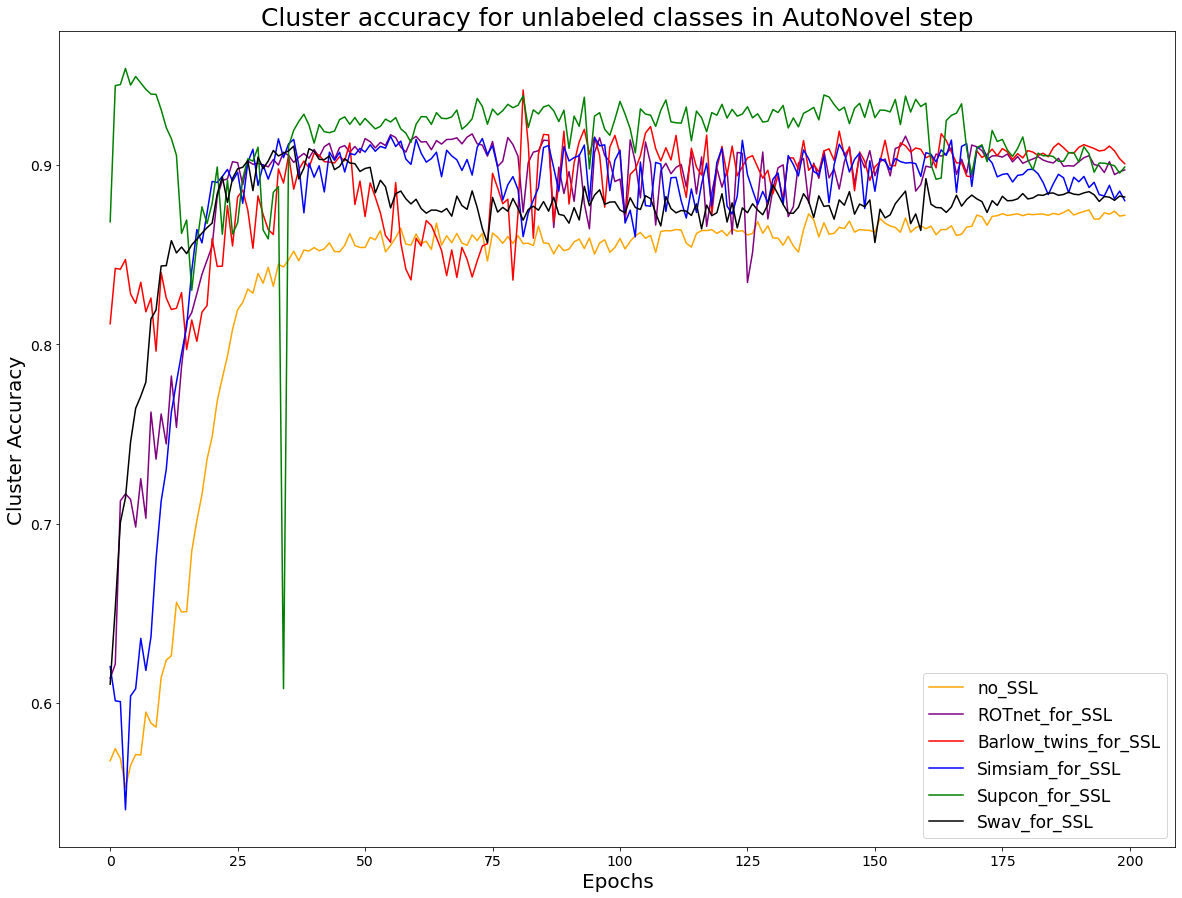

In [62]:
fig, ax= plt.subplots(figsize=(20, 15));
ax.plot(run_old_SL.cluster_acc_Head_2.tolist(), color='orange',label="no_SSL") ;
ax.plot(run_NCD_rotnet.cluster_acc_Head_2.tolist(), color='purple',label="ROTnet_for_SSL") ;
ax.plot(run_NCD_barlow_twins.cluster_acc_Head_2.tolist(), color='red',label="Barlow_twins_for_SSL") ;
ax.plot(run_NCD_simsiam.cluster_acc_Head_2.tolist(), color='blue',label="Simsiam_for_SSL") ;
ax.plot(run_NCD_supcon.cluster_acc_Head_2.tolist(), color='green',label="Supcon_for_SSL") ;
ax.plot(run_NCD_swav.cluster_acc_Head_2.tolist(), color='black',label="Swav_for_SSL") ;

ax.set_xlabel('Epochs',fontsize=20);
ax.set_ylabel('Cluster Accuracy',fontsize=20);
# ax.set_title('Training unlabeled classes accuracy',fontsize=25);
ax.set_title('Cluster accuracy for unlabeled classes in AutoNovel step',fontsize=25);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', framealpha=0.8,fontsize=17)
plt.savefig('images/Model_comparision_for_diff_SSL_AN_STEP.png')

plt.show()

In [63]:
from models.resnet import BasicBlock,resnet_sim,ResNet
from utils.util import cluster_acc, Identity, AverageMeter, accuracy
from data.cifarloader import CIFAR10Loader, CIFAR10LoaderMix

In [64]:
def test(model, test_loader,args):
    # Put the model in evaluation mode
    model.eval()
    # Instantiate two numpy arrays, one for predictions and oen for targets
    preds = np.array([])
    targets = np.array([])
    acc_record = AverageMeter()  # track the accuracy of the first head
    # loss_record = AverageMeter()

    # Iterate for each batch in the dataloader
    for batch_idx, (x, label, _) in enumerate(tqdm(test_loader)):
        # Dataloader contain: X(input sample), label(sample label), index(index of sample in the original dataset)
        # We are interested in using just the sample x and its label to perform supervised learning
        x, label = x.to(device), label.to(device)

        # Output 1, Output2 and Output3 are the results of Head1, Head2, and features-layer4 respectively, we take the
        # outputs of the two heads since we are interested in testing the accuracy of one of the two
        output1, output2, _ = model(x)

        # If the argument head is 'head1' then we take as final output the result of the supervised head
        if args['head'] == 'head1':
            # output1 has size of (128,5), since the batch_size is 128 and the possible classes are 5
            output = output1
        # Otherwise, we take as final output the result of the unsupervised head
        else:
            output = output2
            # label-=args.num_labeled_classes

        # Returns the maximum value for each element in the input tensor, therefore we move from size (128,5) to (128)
        # Here we are not interested in the value, so we put '_' for the first term. We are interested in the second
        # term, which is the index of that value, since the index is equal to the predicted class for that input sample.
        _, pred = output.max(1)

        # Convert tensor to numpy using 'X.cpu.numpy', then append the value in the respective numpy array
        if args['head'] == 'head1':
            acc_testing = accuracy(output, label)  # calculating the accuracy
            acc_record.update(acc_testing[0].item(), x.size(0))
        else:
            acc_testing = 0
        targets = np.append(targets, label.cpu().numpy())
        preds = np.append(preds, pred.cpu().numpy())

    # Compute the accuracy metrics for the current test step, see supervised_learning.py for full explanation
    acc, nmi, ari = cluster_acc(targets.astype(int), preds.astype(int)), nmi_score(targets, preds), ari_score(targets,
                                                                                                              preds)

    print('Test cluster acc {:.4f}, nmi {:.4f}, ari {:.4f}, test accuracy {:.4f}'.format(acc, nmi, ari, acc_record.avg))
    return acc, nmi, ari, acc_record.avg

In [65]:
unlabeled_eval_loader = CIFAR10Loader(root='./data/datasets/CIFAR/', batch_size=128, split='train',
                                              aug=None, shuffle=False,
                                              target_list=range(5, 10))
unlabeled_eval_loader_test = CIFAR10Loader(root='./data/datasets/CIFAR/', batch_size=128, split='test',
                                                   aug=None, shuffle=False,
                                                   target_list=range(5, 10))
all_eval_loader = CIFAR10Loader(root='./data/datasets/CIFAR/', batch_size=128, split='test',
                                        aug=None, shuffle=False, target_list=range(10))
labeled_eval_loader = CIFAR10Loader(root='./data/datasets/CIFAR/', batch_size=128, split='test',
                                            aug=None, shuffle=False, target_list=range(5))

In [66]:
run_new_NCL_model=[ 'resnet_IL_cifar10_NO_rotnet.pth','resnet_IL_cifar10_new_config.pth',
                    'resnet_IL_cifar10_Barlow_twins_2.pth','resnet_IL_cifar10_simsam_2.pth',
                   'resnet_IL_cifar10_supcon_2.pth','resnet_IL_cifar10_swav_2.pth']

In [67]:
args={"head":"head2"}

## baseline for no ssl for new arhiecture

In [68]:
model = resnet_sim(5, 5).to(device)
model.head1 = nn.Linear(512, 10).to(device)
model.load_state_dict(torch.load('data/experiments/auto_novel/'+run_new_NCL_model[0]))

<All keys matched successfully>

### Head 1 

In [69]:
args['head']='head1'
test(model, all_eval_loader,  args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 36.56it/s]

Test cluster acc 0.8192, nmi 0.6916, ari 0.6581, test accuracy 54.7700


(0.8192, 0.6916241800303389, 0.6581030350939674, 54.77)

In [ ]:

test(model, unlabeled_eval_loader_test,  args)

### Head 2

In [70]:
args['head']='head2'

In [71]:
test(model, unlabeled_eval_loader,  args)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:05<00:00, 38.31it/s]


Test cluster acc 0.8720, nmi 0.7188, ari 0.7180, test accuracy 0.0000


(0.87204, 0.7187877924116777, 0.7180272228004314, 0)

In [72]:
test(model, unlabeled_eval_loader_test,  args)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.54it/s]

Test cluster acc 0.8670, nmi 0.7162, ari 0.7098, test accuracy 0.0000


(0.867, 0.7162400239242122, 0.7097863057616941, 0)

In [73]:
del model

## baseline for new archiecture using rotnet

In [74]:
model = resnet_sim(5, 5).to(device)
model.head1 = nn.Linear(512, 10).to(device)
model.load_state_dict(torch.load('data/experiments/auto_novel/'+run_new_NCL_model[1]))

<All keys matched successfully>

### Head 1 

In [75]:
args['head']='head1'
test(model, all_eval_loader,  args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 36.98it/s]

Test cluster acc 0.8853, nmi 0.7903, ari 0.7727, test accuracy 47.1300


(0.8853, 0.7902796914060749, 0.7726603687612141, 47.13)

In [76]:
args['head']='head1'
test(model, unlabeled_eval_loader_test,  args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.45it/s]

Test cluster acc 0.8408, nmi 0.7352, ari 0.7399, test accuracy 1.2800


(0.8408, 0.7351552452694691, 0.7398519687731614, 1.28)

### Head 2

In [77]:
args['head']='head2'

test(model, unlabeled_eval_loader,  args)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:05<00:00, 38.59it/s]


Test cluster acc 0.9030, nmi 0.7918, ari 0.7812, test accuracy 0.0000


(0.90296, 0.7918218103415373, 0.7812178564442299, 0)

In [78]:
test(model, unlabeled_eval_loader_test,  args)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.05it/s]

Test cluster acc 0.8970, nmi 0.7822, ari 0.7681, test accuracy 0.0000


(0.897, 0.7821943685816475, 0.7680634247203061, 0)

In [79]:
del model

## Barlow-twins ssl for step 3 

In [80]:
model = resnet_sim(5, 5).to(device)
model.head1 = nn.Linear(512, 10).to(device)
model.load_state_dict(torch.load('data/experiments/auto_novel/'+run_new_NCL_model[2]))

<All keys matched successfully>

### Head 1 

In [81]:
args['head']='head1'
test(model, all_eval_loader,  args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 36.85it/s]

Test cluster acc 0.8964, nmi 0.8071, ari 0.7892, test accuracy 54.6800


(0.8964, 0.8071405725218687, 0.7892480722395296, 54.68)

In [82]:
args['head']='head1'
test(model, unlabeled_eval_loader_test,  args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.62it/s]


Test cluster acc 0.8642, nmi 0.7500, ari 0.7498, test accuracy 16.5000


(0.8642, 0.7500494175865456, 0.7497579982123078, 16.5)

### Head 2

In [83]:
args['head']='head2'
test(model, unlabeled_eval_loader,  args)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:05<00:00, 38.51it/s]

Test cluster acc 0.9008, nmi 0.7865, ari 0.7714, test accuracy 0.0000


(0.9008, 0.7865403434067029, 0.7714221789928883, 0)

In [84]:
test(model, unlabeled_eval_loader_test,  args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.35it/s]

Test cluster acc 0.8978, nmi 0.7854, ari 0.7659, test accuracy 0.0000


(0.8978, 0.7853940901078657, 0.7659084291624052, 0)

In [85]:
del model

## simsam ssl for step 3 

In [86]:
model = resnet_sim(5, 5).to(device)
model.head1 = nn.Linear(512, 10).to(device)
model.load_state_dict(torch.load('data/experiments/auto_novel/'+run_new_NCL_model[3]))

<All keys matched successfully>

### Head 1 

In [87]:
args['head']='head1'
test(model, all_eval_loader,  args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 37.20it/s]

Test cluster acc 0.8774, nmi 0.7766, ari 0.7540, test accuracy 46.0800


(0.8774, 0.776554436168166, 0.7540369222640201, 46.08)

In [88]:
args['head']='head1'
test(model, unlabeled_eval_loader_test,  args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.29it/s]

Test cluster acc 0.8394, nmi 0.7129, ari 0.7090, test accuracy 0.6200


(0.8394, 0.7129357275135427, 0.70902403725418, 0.62)

### Head 2

In [89]:
args['head']='head2'
test(model, unlabeled_eval_loader,  args)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:05<00:00, 38.18it/s]


Test cluster acc 0.8802, nmi 0.7550, ari 0.7314, test accuracy 0.0000


(0.8802, 0.7550372268105576, 0.7314406284970413, 0)

In [90]:
test(model, unlabeled_eval_loader_test,  args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.89it/s]

Test cluster acc 0.8742, nmi 0.7420, ari 0.7197, test accuracy 0.0000


(0.8742, 0.7420304260709691, 0.7196610136480078, 0)

In [91]:
del model

## Supcon ssl for step 3 

In [92]:
model = resnet_sim(5, 5).to(device)
model.head1 = nn.Linear(512, 10).to(device)
model.load_state_dict(torch.load('data/experiments/auto_novel/'+run_new_NCL_model[4]))

<All keys matched successfully>

### Head 1 

In [93]:
args['head']='head1'
test(model, all_eval_loader,  args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 36.70it/s]

Test cluster acc 0.8917, nmi 0.8210, ari 0.7928, test accuracy 55.1600


(0.8917, 0.8210348869467354, 0.792816172283858, 55.16)

In [94]:
args['head']='head1'
test(model, unlabeled_eval_loader_test,  args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.57it/s]

Test cluster acc 0.8552, nmi 0.7885, ari 0.7621, test accuracy 17.5000


(0.8552, 0.7885063876503339, 0.7620616381119756, 17.5)

### Head 2

In [95]:
args['head']='head2'

test(model, unlabeled_eval_loader,  args)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:05<00:00, 38.22it/s]

Test cluster acc 0.8989, nmi 0.8427, ari 0.8018, test accuracy 0.0000


(0.89892, 0.8427314334000399, 0.801791106458013, 0)

In [96]:
test(model, unlabeled_eval_loader_test,  args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.97it/s]

Test cluster acc 0.8872, nmi 0.8185, ari 0.7793, test accuracy 0.0000


(0.8872, 0.8185231186538177, 0.7793495179105123, 0)

In [97]:
del model

## Swav ssl for step 3 

In [98]:
model = resnet_sim(5, 5).to(device)
model.head1 = nn.Linear(512, 10).to(device)
model.load_state_dict(torch.load('data/experiments/auto_novel/'+run_new_NCL_model[5]))

<All keys matched successfully>

### Head 1 

In [99]:
args['head']='head1'
test(model, all_eval_loader,  args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 36.50it/s]

Test cluster acc 0.8659, nmi 0.7724, ari 0.7448, test accuracy 45.2100


(0.8659, 0.7723934703040669, 0.7448053389877773, 45.21)

In [100]:
args['head']='head1'
test(model, unlabeled_eval_loader_test,  args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.12it/s]

Test cluster acc 0.8318, nmi 0.7394, ari 0.7286, test accuracy 0.4200


(0.8318, 0.7394447884348386, 0.7286462294359601, 0.42)

### Head 2

In [101]:
args['head']='head2'
test(model, unlabeled_eval_loader,  args)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:05<00:00, 37.98it/s]

Test cluster acc 0.8822, nmi 0.7820, ari 0.7590, test accuracy 0.0000


(0.8822, 0.7820056033504533, 0.7589998603342397, 0)

In [102]:
test(model, unlabeled_eval_loader_test,  args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.89it/s]

Test cluster acc 0.8734, nmi 0.7723, ari 0.7452, test accuracy 0.0000


(0.8734, 0.7723317733293279, 0.7452054213356883, 0)

In [103]:
del model

|  SSL  method  | All  classes cluster accuracy (test set) | Unlabeled  classes cluster accuracy (train set) | Unlabeled  classes cluster accuracy (test set) |
|:-------------:|:----------------------------------------:|:-----------------------------------------------:|:----------------------------------------------:|
|     No SSl    |                  0.8192                  |                      0.872                      |                      0.867                     |
|    Rot-net    |                  0.8853                  |                      0.903                      |                      0.897                     |
| Barlow  twins |                  0.8964                  |                      0.901                      |                      0.899                     |
|    Simsiam    |                  0.8774                  |                      0.880                      |                      0.874                     |
|     Supcon    |                  0.8917                  |                      0.899                      |                      0.887                     |
|      Swav     |                  0.8659                  |                      0.882                      |                      0.873                     |

## Domain adaptation

In [104]:
from data.MNISIT_loader import MNISITLoader, MNISITLoaderMix,MNISITLoader_main, MNISITLoaderMix_main


In [105]:
run_MNISIT_BASELINE           = api.run("mhaggag96/trends_project/2maa3o72").history()# 210-MNISIT-BL
run_MNISIT_MIXED              = api.run("mhaggag96/trends_project/3fc3cw36").history()# 187-MNISIT

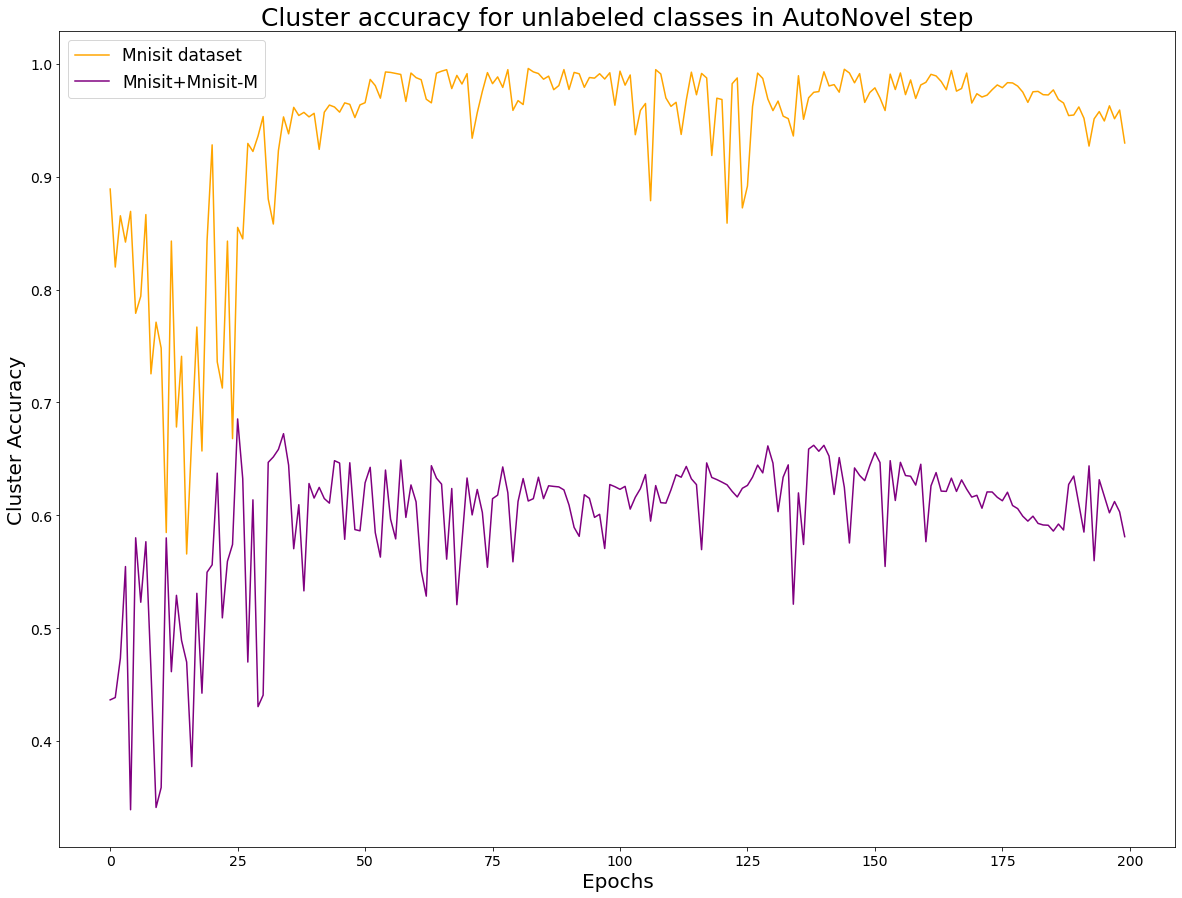

In [106]:
fig, ax= plt.subplots(figsize=(20, 15));
ax.plot(run_MNISIT_BASELINE.cluster_acc_Head_2.tolist(), color='orange',label="Mnisit dataset") ;
ax.plot(run_MNISIT_MIXED.cluster_acc_Head_2.tolist(), color='purple',label="Mnisit+Mnisit-M") ;

ax.set_xlabel('Epochs',fontsize=20);
ax.set_ylabel('Cluster Accuracy',fontsize=20);
ax.set_title('Cluster accuracy for unlabeled classes in AutoNovel step',fontsize=25);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', framealpha=0.8,fontsize=17)
plt.savefig('images/Model_comparision_for_diff_DA_AN_STEP.png')
plt.show()

## Mnisit baseline

### head 1

In [107]:
model=ResNet(BasicBlock, [2, 2, 2, 2], 5, 5).to(device)
model.head1 = nn.Linear(512, 10).to(device)
model.load_state_dict(torch.load('data/experiments/auto_novel/resnet_IL_minsiit_baseline.pth'))

<All keys matched successfully>

In [108]:
unlabeled_eval_loader = MNISITLoader_main( batch_size=128, split='train', aug=None,
                                           shuffle=False, catego='unlabeled',number_of_classes=5)
unlabeled_eval_loader_test = MNISITLoader_main( batch_size=128, split='test',
                                                aug=None, shuffle=False,catego='unlabeled',
                                                number_of_classes=5)
all_eval_loader = MNISITLoader_main( batch_size=128, split='test',
                                        aug=None, shuffle=False,catego='unlabeled',
                                                number_of_classes=10)
labeled_eval_loader = MNISITLoader_main(batch_size=128, split='test',
                                            aug=None, shuffle=False, catego='labeled',
                                                number_of_classes=5)

In [109]:
args['head']='head1'


In [110]:
args['head']='head1'
test(model, unlabeled_eval_loader_test,  args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.42it/s]

Test cluster acc 0.9445, nmi 0.9018, ari 0.8904, test accuracy 15.4906


(0.9444558732771035, 0.9018253497346294, 0.8903717052209281, 15.49063981548059)

In [111]:
test(model, all_eval_loader,  args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 36.61it/s]

Test cluster acc 0.9721, nmi 0.9577, ari 0.9467, test accuracy 58.8300


(0.9721, 0.9576806478486933, 0.946665529109334, 58.83)

### head 2

In [112]:
args['head']='head2'

test(model, unlabeled_eval_loader,  args)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 37.81it/s]

Test cluster acc 0.9299, nmi 0.8800, ari 0.8553, test accuracy 0.0000


(0.9299074955788328, 0.8799914748745147, 0.8553017736460761, 0)

In [113]:
test(model, unlabeled_eval_loader_test,  args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.63it/s]

Test cluster acc 0.9243, nmi 0.8779, ari 0.8478, test accuracy 0.0000


(0.9242954124665707, 0.8778894788619004, 0.8477671731017574, 0)

In [114]:
del model

## domain shift experiment

In [115]:
model=ResNet(BasicBlock, [2, 2, 2, 2], 5, 5).to(device)
model.head1 = nn.Linear(512, 10).to(device)
model.load_state_dict(torch.load('data/experiments/auto_novel/resnet_IL_minsiit_mix.pth'))

<All keys matched successfully>

In [116]:
unlabeled_eval_loader = MNISITLoader( batch_size=128, split='train', aug=None,
                                           shuffle=False, catego='unlabeled',number_of_classes=5)
unlabeled_eval_loader_test = MNISITLoader( batch_size=128, split='test',
                                                aug=None, shuffle=False,catego='unlabeled',
                                                number_of_classes=5)
all_eval_loader = MNISITLoader( batch_size=128, split='test',
                                        aug=None, shuffle=False,catego='unlabeled',
                                                number_of_classes=10)
labeled_eval_loader = MNISITLoader(batch_size=128, split='test',
                                            aug=None, shuffle=False, catego='labeled',
                                                number_of_classes=5)

## head 1 

In [117]:
args['head']='head1'
test(model, unlabeled_eval_loader_test,  args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.27it/s]

Test cluster acc 0.5797, nmi 0.4912, ari 0.3849, test accuracy 15.9021


(0.5797161077967496,
 0.4911610517128878,
 0.38494860216642146,
 15.902077761777411)

In [118]:
test(model, all_eval_loader,  args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 36.70it/s]

Test cluster acc 0.7950, nmi 0.8254, ari 0.7390, test accuracy 59.0500


(0.795, 0.8254470958781714, 0.7390352578093632, 59.05)

## head 2

In [119]:
args['head']='head2'


In [120]:
test(model, unlabeled_eval_loader,  args)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 37.35it/s]

Test cluster acc 0.5811, nmi 0.4878, ari 0.3935, test accuracy 0.0000


(0.5811454223915113, 0.4878164319080536, 0.3934781324055224, 0)

In [121]:
test(model, unlabeled_eval_loader_test,  args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 32.43it/s]


Test cluster acc 0.5733, nmi 0.4781, ari 0.3735, test accuracy 0.0000


(0.5733388191730097, 0.47805562852007855, 0.37348476956058746, 0)

In [ ]:
del model

|            Dataset           | All  classes  cluster accuracy  (test set) | Unlabeled  classes  cluster accuracy (train set) | Unlabeled  classes  cluster accuracy (test set) |
|:----------------------------:|:------------------------------------------:|:------------------------------------------------:|:-----------------------------------------------:|
|          Mnist (0-9)         |                   0.9721                   |                       0.930                      |                      0.924                      |
| Mnist (0-4) + Mnist-M  (5-9) |                    0.795                   |                       0.581                      |                      0.573                      |